In [157]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from math import pi
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from textwrap import wrap

from plotnine import *
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # k-fold 
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn import cluster
from sklearn import metrics
import scipy.cluster.hierarchy as sch

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

#Lebron and Jordan career stats
lebron = pd.read_csv("/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/lebron_career.csv")
jordan = pd.read_csv("/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/jordan_career.csv")

#https://www.kaggle.com/nathanlauga/nba-games
games = pd.read_csv('/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/games.csv')
details = pd.read_csv('/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/games_details.csv')
teams = pd.read_csv('/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/teams.csv')
players = pd.read_csv('/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/players.csv')
ranking = pd.read_csv('/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/ranking.csv')

#Tobi's data
player_df = pd.read_csv('/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/Seasons_Stats.csv')

#shot-chart data
shot_df = pd.read_csv('/Users/tobihowe/Documents/CPSC_392/CPSC392ParlettPelleriti/Data/shotchart_2017.csv')

# Final Project
## National Basketball Association (NBA)
### Tobi Howe & Minmyat Zaw

## Q1: How have basketball positions changed over the years?

The first question I wanted to answer after looking at the data collected on aggregate player statistics was whether basketball positions have changed through time. In traditional basketball, players that play positions such as power-forward and center do not shoot from further out or assist shots frequently, and instead their playstyle primarily focuses on blocks and rebounds. Players that play point guard or shooting guard are players that are more likely to shoot from further out and to have assists as they usually begin the offensive play.

After graphing data on 3-point percentage, block percentage, and other predictors to see trends among the dataset, I noticed that the clusters being formed are not irregularly shaped and there is a lot of overlap between the clusters. These are two areas where a DBSCAN model does poorly, and I decided to change the model I was going to use to solve this question from DBSCAN to a Hierarchical Agglomerative Clustering (HAC) model. 

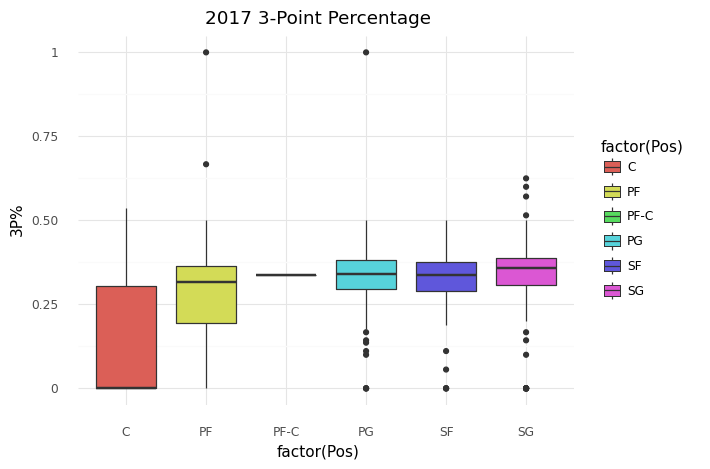

<ggplot: (324436130)>

In [158]:
#Selecting seasons from 2017
player_df17 = player_df.loc[player_df['Year'] == 2017]

#Replacing nulls with a 0
player_df17.fillna(0, inplace = True)

#Boxplot of 3-point percentage by position
(ggplot(player_df17, aes(x = "factor(Pos)", y = "3P%")) + geom_boxplot(aes(fill = "factor(Pos)")) + 
     theme_minimal() + labs(title = "2017 3-Point Percentage"))

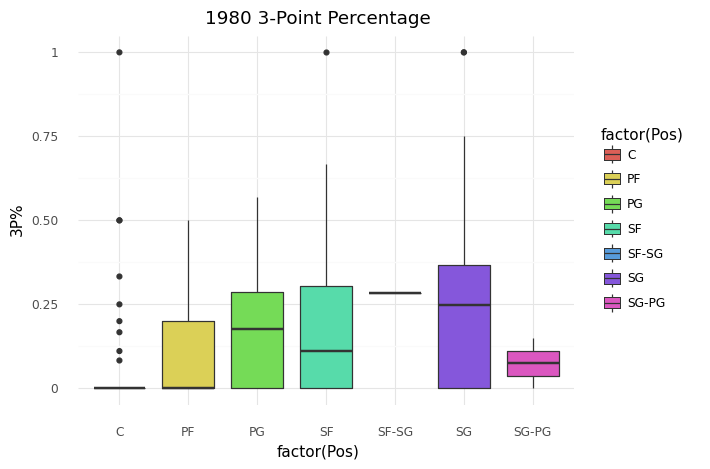

<ggplot: (-9223372036527980386)>

In [159]:
#Selecting 1980 season
player_df80 = player_df.loc[player_df['Year'] == 1980]

##Replacing nulls with a 0
player_df80.fillna(0, inplace = True)

#Boxplot of 3-point percentage by position
(ggplot(player_df80, aes(x = "factor(Pos)", y = "3P%")) + geom_boxplot(aes(fill = "factor(Pos)")) +
     theme_minimal() + labs(title = "1980 3-Point Percentage"))

The two graphs above compare 3-point percentage by position in 1980 and 2017. When the 3-point shot was first introduced, the only players who attempted the shot were point guards, shooting guards, and small forwards. Centers rarely took any 3-point shots. However, when one looks at the 2017 3-point percentage, one can see that the overall averages for each position have increased significantly. On top of that the range of the data is a lot smaller and centered around each mean. This indicates that players have similar shooting efficiency besides a few outliers. There are centers taking 3-point shots as well in the modern game and some have high 3-point percentages. 

To further answer this question I tried to cluster players by position using the following predictors: 3-point percentage, assist percentage, block percentage, total rebound percentage, effective field goal percentage, field goal percentage, free-throw percentage, and steal percentage. Effective field goal percentage is similar to field goal percentage but takes into account that 3-point shots are worth more than 2-point shots. The distance metric I used was euclidean as the data is continuous and I used the wards method as the linkage criteria. I decided to use 5 clusters after looking at the dendrogram below and because there are 5 positions in basketball.

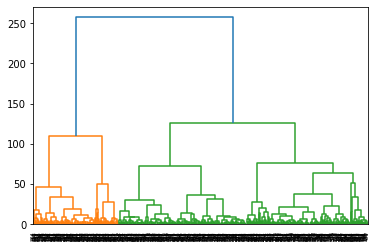

In [160]:
predictors = ["3P%", "AST%", "BLK%", "TRB%", "eFG%", "FG%", "FT%", "STL%"]

X = player_df17[predictors]
y = player_df17["Pos"]

#Making HAC model eaching eaclidean and I used wards method 
#as all my predictors are continuous.
hac = AgglomerativeClustering(affinity = "euclidean",
                             linkage = "ward")

hac.fit(X) #fitting HAC model

dendro = sch.dendrogram(sch.linkage(X, method='ward'))

In [161]:
#Using 5 clusters because of the dendrogram above and the 5 positions in basketball
hac = AgglomerativeClustering(n_clusters = 5, 
                              affinity = "euclidean",
                             linkage = "ward")

hac.fit(X) #fit model

membership = hac.labels_

silscore17 = silhouette_score(X, membership) #silhouette score

print("Silhouette score for our model on the 2017 season: ", silscore17)

Silhouette score for our model on the 2017 season:  0.31508316445970025


The silhouette score for the 2017 season is 0.3151. From looking at the graphs this is most likely because the clusters are very cohesive but not that separated. The clusters are stacked on top of each other which is why the silhouette score is not very high.

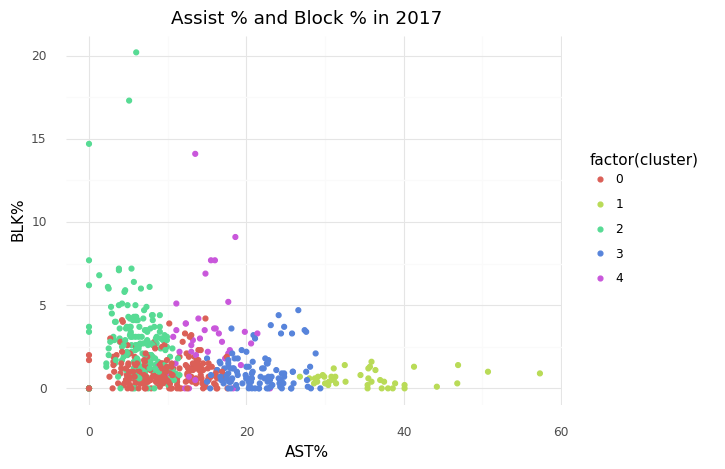

<ggplot: (330499981)>

In [162]:
player_df17["cluster"] = membership

#Assist and block percentage for 2017
(ggplot(player_df17, aes(x = "AST%", y = "BLK%")) + geom_point(aes(color = "factor(cluster)")) + 
     theme_minimal() + labs(title = "Assist % and Block % in 2017"))

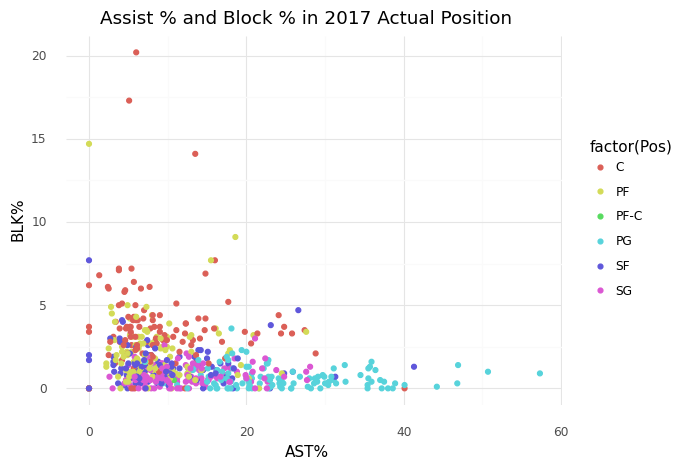

<ggplot: (-9223372036529588592)>

In [163]:
(ggplot(player_df17, aes(x = "AST%", y = "BLK%")) + geom_point(aes(color = "factor(Pos)")) + 
     theme_minimal() + labs(title = "Assist % and Block % in 2017 Actual Position"))

This ggplot shows 5 distinct clusters in the data. The green is most likely centers who have a lot of blocks during a game but relatively low numbers of assists. The red is most likely power-forwards and the purple most likeley small-forwards. The blue cluster most likely represents the shooting guards and the light green cluster represents point guards. We make this prediction because these are players who typically are not as tall as forwards but are more technical and create opportunities to score. Compared to the actual plot of block percentage and assist percentage we see that our cluster is fairly accurate at predicting the clusters. It is hard to precisely tell due to the overlap between the positions but we can see that our model does well at predicting the point guard position but not as well for the shooting guard and small forward position

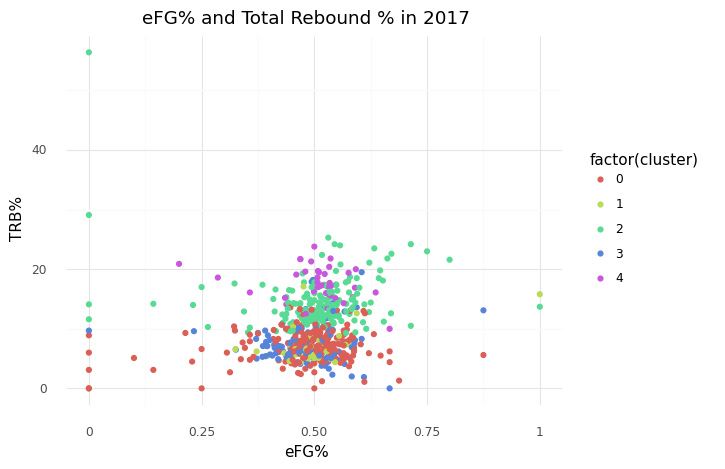

<ggplot: (332515753)>

In [164]:
#eFG% and TRB% for 2017 season
(ggplot(player_df17, aes(x = "eFG%", y = "TRB%")) + geom_point(aes(color = "factor(cluster)")) + 
     theme_minimal() + labs(title = "eFG% and Total Rebound % in 2017"))

The graph above compares effective field goal percentage and total rebound percentage. The green cluster is most likely centers or powerforwards because they are able to get a lot of rebounds each game. The red cluster is most likely point guards or shooting guards because they have a similar effective field goal percentage but not as many rebounds as the other positions. When looking at effective field goal percentage we can see that the clusters are all focused around an effective field goal percentage of 50%. After analyzing the model on the 2017 data, I used the cluster on the 1980 dataset.

In [165]:
#Using HAC model to estimate clusters using 1980 data
X = player_df80[predictors]
y = player_df80["Pos"]

hac = AgglomerativeClustering(n_clusters = 5, #Using 5 clusters because of the 5 positions in basketball
                              affinity = "euclidean",
                             linkage = "ward")

hac.fit(X)

membership = hac.labels_

silscore80 = silhouette_score(X, membership)

player_df80["cluster"] = membership

print("Silhouette score for our model on the 1980 season: ", silscore80)

Silhouette score for our model on the 1980 season:  0.3206475140538006


The silhouette score for the 1980 season is 0.3206 which is slightly better than the silhouette score for the 2017 model. Although the two models cluster the data in a similar way, the range for the 2017 data is a lot larger than the 1980 data.

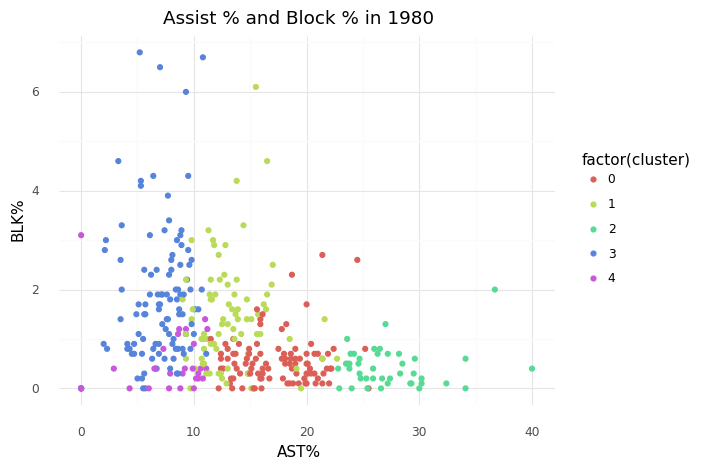

<ggplot: (-9223372036531191899)>

In [166]:
(ggplot(player_df80, aes(x = "AST%", y = "BLK%")) + geom_point(aes(color = "factor(cluster)")) + 
     theme_minimal() + labs(title = "Assist % and Block % in 1980"))

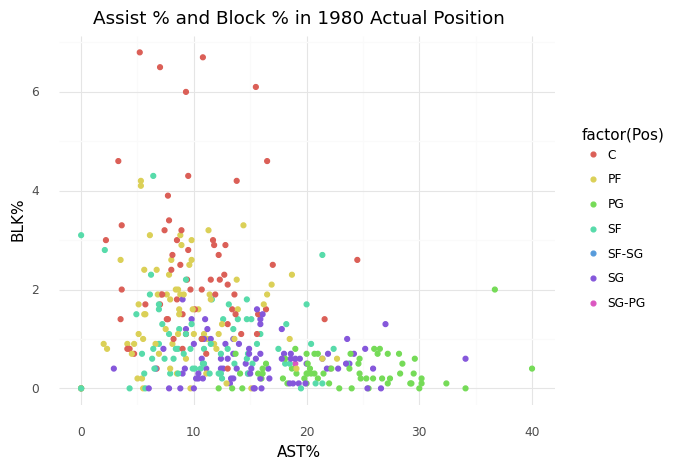

<ggplot: (339239309)>

In [167]:
(ggplot(player_df80, aes(x = "AST%", y = "BLK%")) + geom_point(aes(color = "factor(Pos)")) + 
     theme_minimal() + labs(title = "Assist % and Block % in 1980 Actual Position"))

The graph for assist percentage and block percentage looks very similar for both the 1980 and 2017 dataset. There are clear trends in the data such as the blue cluster most likely being players who play the center position becuause of the high block percentage and low assist percentage. Point guards are most likely the green cluster and the red cluster is most likely shooting guards as these are players who have a lot of assists but not that many blocks. Compared to the actual plot that shows block percentage and assist percentage by position we see that the center and power forward position are clustered in a similar way as the model. The biggest difference between our model and the actual plot is the small forward position because of the wide range of statistics there are for that position. A lot of these players were grouped into the center and power forward position in our model.

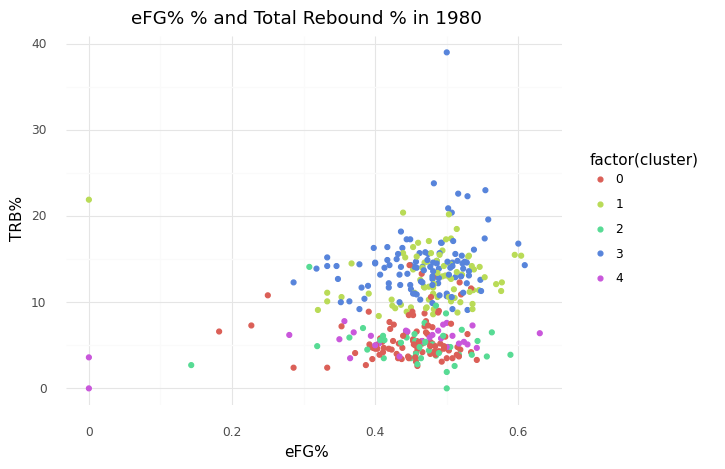

<ggplot: (-9223372036515542093)>

In [168]:
(ggplot(player_df80, aes(x = "eFG%", y = "TRB%")) + geom_point(aes(color = "factor(cluster)")) + 
     theme_minimal() + labs(title = "eFG% % and Total Rebound % in 1980"))

The graph above compares effective field goal percentage to total rebound percentage. The light green and blue cluster in this data are most likely the bigger players such as centers and power forwards as they usually accumulate more rebounds during a game due to their height. The red and dark green cluster are most likeley guards such as point guards and shooting guards as they do not have as many rebounds per game usually. 

Using the HAC model on the 1980 dataset creates similar clusters to the 2017 model. The clusters most likely represent point-guards (light-green), shoooting-guards (red), small-forwards (dark green), power forwards (purple), and centers (blue). The biggest difference between the 1980 and the 2017 data are the ranges for each variable. In 1980 the assist percentage in the league ranged from 0%-40% with most between 0%-30%. The block percentage ranges from 0%-7% with most between 0%-4%. In 2017 however, assist percentage ranges from 0%-60% with most players averaging 0%-40%. The block percentage ranges from 0%-20% with most between 0%-8%. This significant increase demonstrates how the game has evolved. 

### Conclusion
From looking at the clusters created from the HAC model we can see that there are similar trends in both the 1980-81 season and the 2017-18 season. This demonstrates that despite the introduction of the 3-point shot, each position plays in a similar playstyle as they did in 1980. However, the biggest difference we see over time is the range of data. In 2017 we see that the average block, assist, effecting field goal, and total rebound percentage has increased since 1980. This indicates that the quality of the game has increased and players are becoming better and better.

This data can be utilized by teams who are looking at potential free agent signings to compare how efficient each player is according to their position. It can also be used to identify players on their own team who are not performing as efficiently as other players in the league in their position.

## Q2. Are 3-point shots more significant in modern basketball?

To further understand how the game has changed, we will focus on the 3-point shot as it has become an integral part of teams in modern basketball. Below are graphs that display the increase in 3-points attempted and 3-point percentage over time.

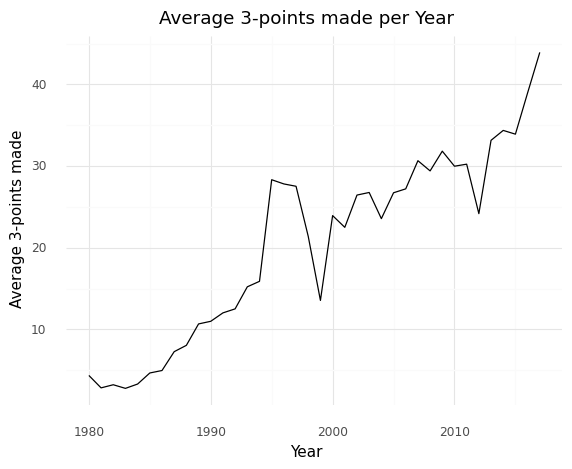

<ggplot: (-9223372036531021673)>

In [169]:
#Are 3-point shots more significant in modern basketball than in traditional basketball?
player_df79 = player_df.loc[player_df['Year'] > 1979]

predictor_3pt = ["Year",'3P', '3PA', '3P%']
average_df = player_df79[predictor_3pt]

#Replacing nulls with a 0
average_df.fillna(0, inplace = True)

average_df = average_df.groupby("Year") #group by year
average_df = average_df.mean() #get average
average_df = average_df.reset_index() #reset to match format

(ggplot(average_df, aes(x = "Year", y = "3P")) + geom_line() + theme_minimal() + 
     labs(y = "Average 3-points made", title = "Average 3-points made per Year"))

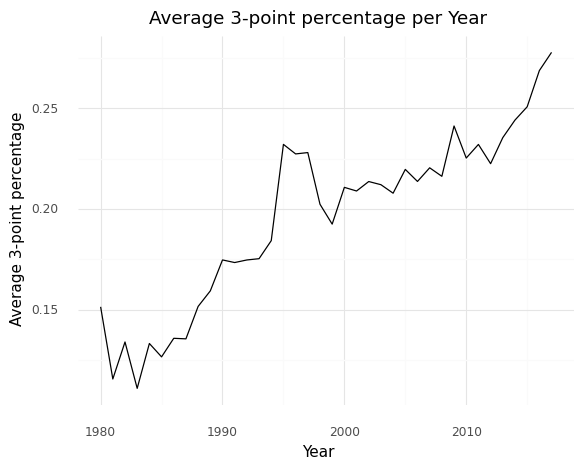

<ggplot: (323656445)>

In [170]:
(ggplot(average_df, aes(x = "Year", y = "3P%")) + geom_line() + theme_minimal() + 
     labs(y = "Average 3-point percentage", title = "Average 3-point percentage per Year"))

We can see from the graph above that 3-point percentage and 3-point shots made has increased significantly since the introduction of the shot. This indicates that players are becoming more and more accurate at shooting 3-pointers. In 1980 when the rule was introduced the 3-point percentage in the NBA was around 5% but has increased to over 40%. Although the 3-point percentage in the league as well as attempted 3-pointers has increased over time, I wanted to analyze if it has significantly affected a player's effective field goal percentage. The effective field goal percentage recognizes that 3-pointers are worth more than 2-pointers and adjusts field goal percentage to account for this. It is a commonly used indicator to analyze a player's shooting efficiency.

In [171]:
#Selecting seasons after 1979 when 3-point shot was introduced
player_df79 = player_df.loc[player_df['Year'] > 1979]

predictors2 = ["Year", "2P%", "3P%", "TS%", "FT%"]
X = player_df79[predictors2]


outcome = ["Year", "eFG%"]
y = player_df79[outcome] #effective field goal percentage

#Replacing nulls with a 0
y.dropna()

y = y.groupby("Year") #group by year
mean_y = y.mean() #get average
mean_y = mean_y.reset_index() #reset to match format
mean_y.drop('Year', axis=1, inplace=True)

#Replacing nulls with a 0
X.dropna()

X = X.groupby("Year") #group by year
mean_X = X.mean() #calculate mean
mean_X = mean_X.reset_index() #reset to match format
mean_X.drop('Year', axis=1, inplace=True)

In [172]:
df_fg = mean_X #adding mean_X to the df_fg dataframe
df_fg["eFG%"] = mean_y["eFG%"] #add eFG% to the df

predictors3 = ["2P%", "3P%", "TS%", "FT%"]

X = df_fg[predictors3]
y = df_fg["eFG%"] #add eFG% to df

lr = LinearRegression()

kf = KFold(4) #creating a k-fold with 3 folds
mse = []
r2 = []

for train,test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]
    
    z = StandardScaler() #z-score continuous variables
    Xz_train = z.fit_transform(X_train) 
    Xz_test = z.transform(X_test)
    
    # model
    model = lr.fit(Xz_train, y_train) #fit model
    # record accuracy
    mse.append(mean_squared_error(y_test, model.predict(Xz_test))) #append mse
    r2.append(r2_score(y_test,model.predict(Xz_test))) #append R2
    
print("The MSE is :", np.mean(mse)) #print MSE
print("The R2 is :", np.mean(r2)) #print R2

The MSE is : 1.9420034806772773e-05
The R2 is : 0.6518511098045152


The MSE for our model is extremely low but the R2 is only 65.19%. This means that 65.19% of the variability in effective field goal percentage is accounted for by the four predictor variables, 2P%, 3P%, TS%, and FT%. This indicates that our model is fairly accurate due to the low MSE but cannot account for all the patterns we see in the data.

In [173]:
true_vs_pred = pd.DataFrame({"predict": model.predict(Xz_test),"trueV": y_test}) #true vs predicted

true_vs_pred.head()

,predict,trueV
29,0.472338,0.477955
30,0.474529,0.476937
31,0.470810,0.475558
32,0.463335,0.465955
33,0.461826,0.465942


In [174]:
coefficients = pd.DataFrame({"Name": predictors3, 
                             "Coef":model.coef_})

coefficients = coefficients.append({"Name": "intercept",
                    "Coef": model.intercept_}, ignore_index = True)

coefficients

,Name,Coef
0,2P%,0.004707
1,3P%,0.002397
2,TS%,0.006170
3,FT%,-0.001348
4,intercept,0.459369


Our linear model on the data from 1980 to 2017 indicates that the most significant variable in predicting effective field goal percentage is the true shooting percentage. True shooting percentage accounts for 2-point field goal percentage, 3-point field goal percentage, and free-throw percentage, and is an accurate measure of a player's efficiency. The coefficient for 3-point percentage is 0.002397 which indicates a 100% increase in 3-point percentage results in a 0.2397% increase in effective field goal percentage. In this context, the coefficients are hard to interpret but I want to focus on the coefficient itself and see if it increases. This would indicate that 3P% is more significant in predicting effective field goal percentage, and that the 3-point shot has become more effective.

In [175]:
#Selecting 1980 to 1999 seasons to look at older trend
player80to99_df = player_df.loc[(player_df['Year'] >= 1980) & (player_df['Year'] < 1999)]

X = player80to99_df[predictors2]
y = player80to99_df[outcome] #effective field goal percentage

##Replacing nulls with a 0
player80to99_df.fillna(0, inplace = True)

y = y.groupby("Year") #group by year
mean_y = y.mean() #get average
mean_y = mean_y.reset_index() #reset to match format
mean_y.drop('Year', axis=1, inplace=True)

##Replacing nulls with a 0
player80to99_df.fillna(0, inplace = True)

X = X.groupby("Year") #group by year
mean_X = X.mean() #calculate mean
mean_X = mean_X.reset_index() #reset to match format
mean_X.drop('Year', axis=1, inplace=True)

#print(mean_X)

In [176]:
fg_df8099 = mean_X #store means into dataframe
fg_df8099["eFG%"] = mean_y["eFG%"]

X = fg_df8099[predictors3]
y = fg_df8099["eFG%"]

lr = LinearRegression()

kf = KFold(3)

mse = []
r2 = []

for train,test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]
    
    z = StandardScaler()
    Xz_train = z.fit_transform(X_train)
    Xz_test = z.transform(X_test)
    
    # model
    model = lr.fit(Xz_train, y_train)
    

coefficients = pd.DataFrame({"Name": predictors3, 
                             "Coef":model.coef_})

coefficients = coefficients.append({"Name": "intercept",
                    "Coef": model.intercept_}, ignore_index = True)

coefficients

,Name,Coef
0,2P%,0.007054
1,3P%,0.001406
2,TS%,-0.000604
3,FT%,-0.000581
4,intercept,0.462636


Above are the coefficients for our model when we look at the range of seasons from 1980 to 1999. As one can see the most significant variable in predicting effective field goal percentage is 2-point percentage. 3-point percentage's coefficient is only 0.001406 which indicates it is not significant in predicting eFG%. Interestingly true shooting percentage and free throw percentage are inversely correlated with effective field goal percentage. This implies that the higher the true shooting percentage and free throw percentage a player has, the lower their effective field goal percentage is.

In [177]:
#Selecting 2000 - 2017 seasons to look at recent trend
player_df00 = player_df.loc[player_df['Year'] >= 2000]

X = player_df00[predictors2]
y = player_df00[outcome] #effective field goal percentage

##Replacing nulls with a 0
player_df00.fillna(0, inplace = True)

y = y.groupby("Year") #group by year
mean_y = y.mean() #get average
mean_y = mean_y.reset_index() #reset to match format
mean_y.drop('Year', axis=1, inplace=True)

##Replacing nulls with a 0
player_df00.fillna(0, inplace = True)

X = X.groupby("Year") #group by year
mean_X = X.mean() #calculate mean
mean_X = mean_X.reset_index() #reset to match format
mean_X.drop('Year', axis=1, inplace=True)

In [178]:
fg_df00 = mean_X #store means into dataframe
fg_df00["eFG%"] = mean_y["eFG%"]

X = fg_df00[predictors3]
y = fg_df00["eFG%"]

lr = LinearRegression()

kf = KFold(3)

mse = []
r2 = []

for train,test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]
    
    z = StandardScaler()
    Xz_train = z.fit_transform(X_train)
    Xz_test = z.transform(X_test)
    
    # model
    model = lr.fit(Xz_train, y_train)
    

coefficients = pd.DataFrame({"Name": predictors3, 
                             "Coef":model.coef_})

coefficients = coefficients.append({"Name": "intercept",
                    "Coef": model.intercept_}, ignore_index = True)

coefficients

,Name,Coef
0,2P%,0.006475
1,3P%,0.001846
2,TS%,0.005264
3,FT%,-0.000604
4,intercept,0.459713


Above is the same linear model ran on the seasons 2000 to 2017 and analyzing the effect 2-point percentage, 3-point percentage, true shooting percentage, and free throw percentage has on effective field goal percentage. The coefficient for 3-point percentage is 0.001846 which is an increase from the coefficient in 1980-1999 model of 0.001406 by 0.00044. Although this is a very small increase, it indicates that 3-point percentage has become more significant. Below I will look at more specific trends by comparing the 1980 season and 2017 season.

In [179]:
#Comparing more specific trends from 1980 to 2017

#Selecting 1980 season for most older trends
player_df80 = player_df.loc[player_df['Year'] == 1980]
player_df80["Player_ID"] = player_df80.iloc[:, :1]

##Replacing nulls with a 0
player_df80.fillna(0, inplace = True)
#player_df80.dropna()

predictors4 = ["Player_ID", "2P%", "3P%", "TS%", "FT%"]
X = player_df80[predictors4]

outcome2 = ["Player_ID", "eFG%"]
y = player_df80[outcome2] #effective field goal percentage



y = y.groupby("Player_ID") #group by player id
mean_y = y.mean() #get average
mean_y = mean_y.reset_index() #reset to match format

X = X.groupby("Player_ID") #group by player id
mean_X = X.mean() #calculate mean
mean_X = mean_X.reset_index() #reset to match format

#mean_X

In [180]:
df80 = mean_X #store means into dataframe
df80["eFG%"] = mean_y["eFG%"]

X = df80[predictors3]
y = df80["eFG%"]

lr = LinearRegression()

kf = KFold(3)

mse = []
r2 = []

for train,test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]
    
    z = StandardScaler()
    Xz_train = z.fit_transform(X_train)
    Xz_test = z.transform(X_test)
    
    # model
    model = lr.fit(Xz_train, y_train)
    

coefficients = pd.DataFrame({"Name": predictors3, 
                             "Coef":model.coef_})

coefficients = coefficients.append({"Name": "intercept",
                    "Coef": model.intercept_}, ignore_index = True)

coefficients

,Name,Coef
0,2P%,0.067043
1,3P%,0.006256
2,TS%,0.010759
3,FT%,-0.003305
4,intercept,0.458143


The coefficients for the 1980 season model are displayed above and one can see that 2-point percentage and 3-point percentage are significant in predicting effective field goal percentage. 3-point percentage on the other hand has a coefficient of only 0.006256 which indicates a 100% increase in 3-point percentage results in a 0.6256% increase in effective field goal percentage. 

In [181]:
#Selecting 2017 season for more recent trends
player_df00 = player_df.loc[player_df['Year'] == 2017]
player_df00["Player_ID"] = player_df00.iloc[:, :1]

##Replacing nulls with a 0
player_df00.fillna(0, inplace = True)
#player_df80.dropna()

predictors4 = ["Player_ID", "2P%", "3P%", "TS%", "FT%"]
X = player_df00[predictors4]

outcome2 = ["Player_ID", "eFG%"]
y = player_df00[outcome2] #effective field goal percentage



y = y.groupby("Player_ID") #group by player id
mean_y = y.mean() #get average
mean_y = mean_y.reset_index() #reset to match format

X = X.groupby("Player_ID") #group by player id
mean_X = X.mean() #calculate mean
mean_X = mean_X.reset_index() #reset to match format

In [182]:
df00 = mean_X #store means into dataframe
df00["eFG%"] = mean_y["eFG%"]

X = df00[predictors3]
y = df00["eFG%"]

lr = LinearRegression()

kf = KFold(3)

mse = []
r2 = []

for train,test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]
    
    z = StandardScaler()
    Xz_train = z.fit_transform(X_train)
    Xz_test = z.transform(X_test)
    
    # model
    model = lr.fit(Xz_train, y_train)
    

coefficients = pd.DataFrame({"Name": predictors3, 
                             "Coef":model.coef_})

coefficients = coefficients.append({"Name": "intercept",
                    "Coef": model.intercept_}, ignore_index = True)

coefficients

,Name,Coef
0,2P%,0.025177
1,3P%,0.010820
2,TS%,0.082465
3,FT%,-0.014366
4,intercept,0.492262


In the 2017 linear model, one can see a significant increase in the coefficient for 3-point percentage which is now 0.018390. The intepretation of this would be, a 100% increase in 3-point percentage results in a 1.8390% increase in effective field goal percentage. This data provides strong evidence that not only are 3-point shots becoming more accurate and more incorporated into modern day basketball, they are becoming more effective and contributing more to a player's field goal percentage.

### Conclusion
It is clear to see when watching a game of basketball today that the 3-point shot is utilized more frequently than it used to. To answer the question of whether the 3-point shot has become more significant in today's basketball I compared the coefficients for 3-point percentage over time. The linear model that was used to predict effective field goal percentage demonstrated that in 2017 the 3-point shot had become more significant at predicting effective field goal percentage. This can be seen by the increase in coefficients when comparing the 1979-1999 model and the 2000-2017 model, and when comparing the 1980 model and the 2017 model. 

This data can be used for teams and coaches to decide which type of shot to priorize and to decide whether they should create plays that lead to 3-point shots. Our data indicates that the 3-point shot has become more significant in modern basketball and teams should utilize it.

## Q3. Has the type of shot players take changed?

#### Dirk Nowitzki 1999-2000 Season

In the dataset I found, Dirk Nowitzki is the player with the oldest data available and has statistics on his shot chart in the 1999 to 2000 season. Dirk Nowitzki was runner-up for the Most Improved Player award and competed in the 3-point contest. Below is his shot chart for all his made shots during the season.

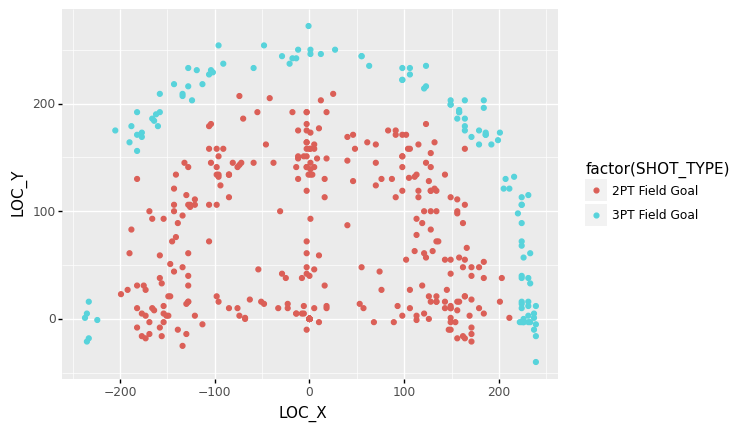

<ggplot: (-9223372036526264537)>

In [183]:
#Dirk Nowitzki 1999-00 season
season9900 = shot_df.loc[(shot_df["GAME_DATE"] > 19991001) & (shot_df["GAME_DATE"] < 20000801)]
nowitzki = season9900.loc[season9900['PLAYER_NAME'] == "Dirk Nowitzki"]
nowitzki_made = nowitzki.loc[nowitzki["SHOT_MADE_FLAG"] == 1]

ggplot(nowitzki_made, aes(x = "LOC_X", y = "LOC_Y")) + geom_point(aes(color = "factor(SHOT_TYPE)"))

In [184]:
# we ask for mins + 1 nearest, because the data point it self (distance = 0) is included
mins = 5
nn = NearestNeighbors(mins + 1)

nn.fit(nowitzki_made[["LOC_X", "LOC_Y"]])

distances, neighbors = nn.kneighbors(nowitzki_made[["LOC_X", "LOC_Y"]])

distances

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  8.        , 14.76482306, 18.43908891, 23.        ,
        23.53720459],
       [ 0.        , 18.78829423, 21.40093456, 31.06444913, 31.32091953,
        33.83784863],
       ...,
       [ 0.        ,  2.82842712, 19.        , 20.24845673, 24.04163056,
        25.70992026],
       [ 0.        ,  8.06225775,  8.54400375,  9.48683298, 10.        ,
        11.18033989],
       [ 0.        ,  2.82842712,  6.32455532,  9.21954446, 10.29563014,
        12.04159458]])

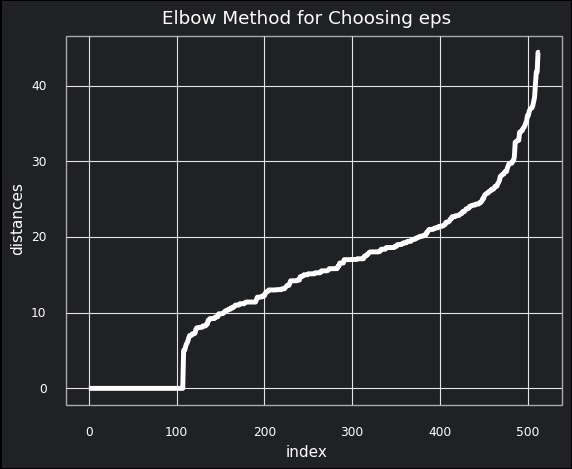

<ggplot: (-9223372036531059845)>

In [185]:
# sort the distances
distances = np.sort(distances[:, mins], axis = 0)

#plot the distances
distances_df = pd.DataFrame({"distances": distances,
                             "index": list(range(0,len(distances)))})
pl = (ggplot(distances_df, aes(x = "index", y = "distances")) +
 geom_line(color = "white", size = 2) + theme_minimal() +
 labs(title = "Elbow Method for Choosing eps") +
 theme(panel_grid_minor = element_blank(),
      rect = element_rect(fill = "#202124ff"),
      axis_text = element_text(color = "white"),
      axis_title = element_text(color = "white"),
      plot_title = element_text(color = "white"),
      panel_border = element_line(color = "darkgray"),
      plot_background = element_rect(fill = "#202124ff")
      ))
ggsave(plot=pl, filename='elbow.png', dpi=300)

pl

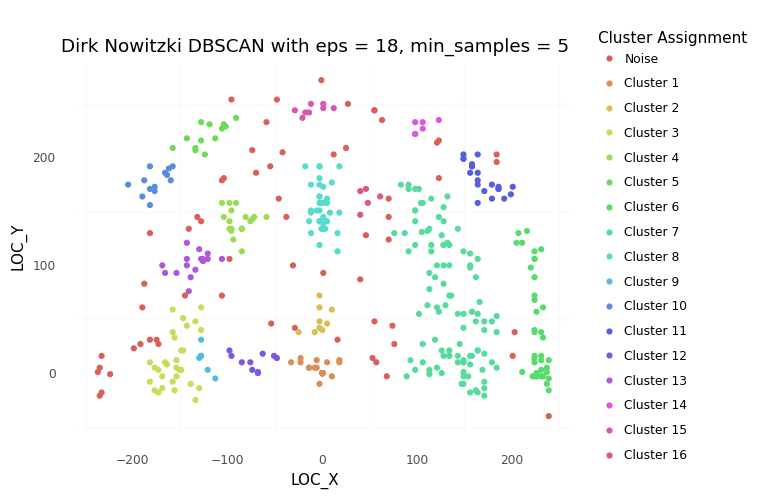

<ggplot: (-9223372036531177805)>

In [186]:
db1 = DBSCAN(eps = 18, min_samples = 5).fit(nowitzki_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

nowitzki_made["assignments"] = db1.labels_

(ggplot(nowitzki_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Dirk Nowitzki DBSCAN with eps = 18, min_samples = 5"))

In [187]:
# grab only clustered data points
nowitzki_clustered = nowitzki_made.loc[(nowitzki_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(nowitzki_clustered[["LOC_X","LOC_Y"]], nowitzki_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(nowitzki_made[["LOC_X","LOC_Y"]], nowitzki_made["assignments"]))

Clustered silhouette score:  0.5151923237888566
Overall silhouette score:  0.3643253169265996


Using DBSCAN I clustered the shot-chart for Dirk Nowitzki to locate his hot spots and where he frequently takes shots from. From this graph we can see that Nowitzki primarily takes shots from mid-range and from the 3-point shot. Cluster 3 appears to be the largest cluster and may be Nowitzki's favorite place to shoot from. The clustered silhouette score was 0.5152 which is fairly good and indicates that the clusters are somewhat cohesive and separated from other clusters. The overall silhouette score is 0.3644. The silhouette score for the clustered is fairly strong which is due to how cohesive clusters are and the clusters are also fairly separated.

Another player that played during the same time was Tony Parker for the San Antonio Spurs who played point guard, and is another player to compare more recent players to.

#### Tony Parker 2001-02 Season

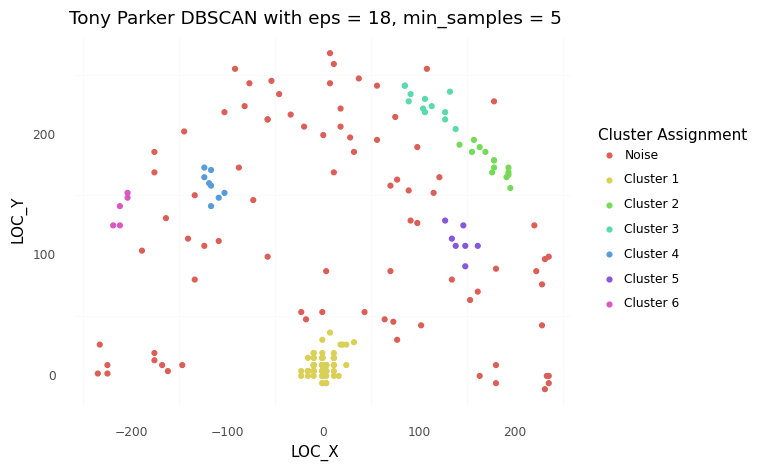

<ggplot: (-9223372036531065768)>

In [188]:
#Tony Parker 01-02 season by quarter
season0102 = shot_df.loc[(shot_df["GAME_DATE"] > 20011001) & (shot_df["GAME_DATE"] < 20020801)]
parker = season0102.loc[season0102['PLAYER_NAME'] == "Tony Parker"]
parker_made = parker.loc[parker["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(parker_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

parker_made["assignments"] = db1.labels_

(ggplot(parker_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Tony Parker DBSCAN with eps = 18, min_samples = 5"))

In [189]:
# grab only clustered data points
parker_clustered = parker_made.loc[(parker_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(parker_clustered[["LOC_X","LOC_Y"]], parker_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(parker_made[["LOC_X","LOC_Y"]], parker_made["assignments"]))

Clustered silhouette score:  0.8745026021229426
Overall silhouette score:  0.427413852405352


Tony Parker was not a prolific scorer but was a key player for the Spurs. From the model the two large clusters for Tony Parker's shot-chart are under the basket and the 2 clusters on the right 3-point line. The clustered silhouette score was very good with 0.8745 but the overall was 0.4274. The reason why the clustered silhouette score is so high is because the clusters are very cohesive like the one under the basket and very separated as the next closest cluster is the purple cluster. 

After making the model on Tony Parker, I decided to analyze data on the MVP winners for the NBA from the 2008-09 season to the 2020-2021 as in-depth data is provided for these season. Below are the previous MVP winners.

2008-09 - Lebron James

2009-10 - Lebron James

2010-11 - Derrick Rose (Could not acquire data)

2011-12 - Lebron James (Could not acquire data)

2012-13 - Lebron James (Could not acquire data)

2013-14 - Kevin Durant (Could not acquire data)

2014-15 - Stephen Curry

2015-16 - Stephen Curry

2016-17 - Russell Westbrook

2017-18 - James Harden

2018-19 - Giannis Antetokounmpo

2019-20 - Giannis Antetokounmpo

2020-21 - Nikola Jokic

#### LeBron James 2008-09 Season

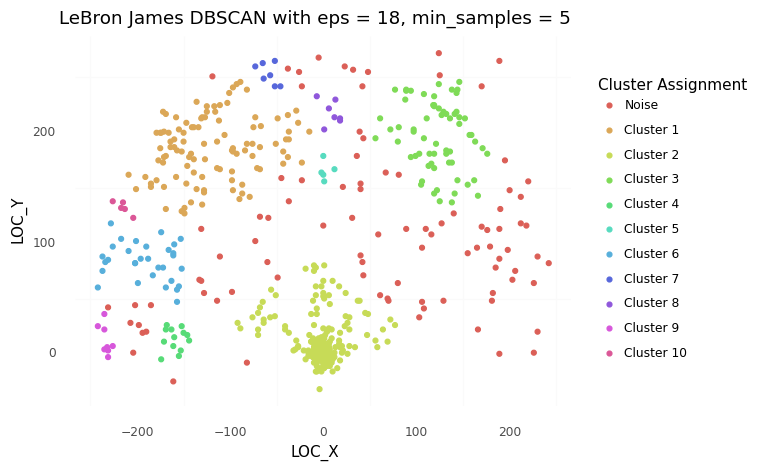

<ggplot: (339235746)>

In [190]:
#Lebron 08-09 season by quarter
season0809 = shot_df.loc[(shot_df["GAME_DATE"] > 20081001) & (shot_df["GAME_DATE"] < 20090801)]
leb = season0809.loc[season0809['PLAYER_NAME'] == "LeBron James"]
lebron_made = leb.loc[leb["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(lebron_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

lebron_made["assignments"] = db1.labels_

(ggplot(lebron_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "LeBron James DBSCAN with eps = 18, min_samples = 5"))

In [191]:
# grab only clustered data points
lebron_clustered = lebron_made.loc[(lebron_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(lebron_clustered[["LOC_X","LOC_Y"]], lebron_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(lebron_made[["LOC_X","LOC_Y"]], lebron_made["assignments"]))

Clustered silhouette score:  0.6506742260040548
Overall silhouette score:  0.5130593073616576


Above is the DBSCAN model created for LeBron James's 2008-09 MVP winning season. Fromt the clustering we can see that there are distinct areas where Lebon is taking the majority of his shots. He takes most of them from underneath the basket in the restricted area. When he shoots from further out, he primarily shoots from the left-side of the court and rarely shoots from the right-corner and from mid-range. On LeBron's 2008-09 season the clustered silhouette score is 0.6507 and the overall is 0.5131. The model does well on the 2008-09 LeBron shot-chart as it is able to identify areas that LeBron James shoots the majority of his shots.

#### LeBron James 2009-10 Season

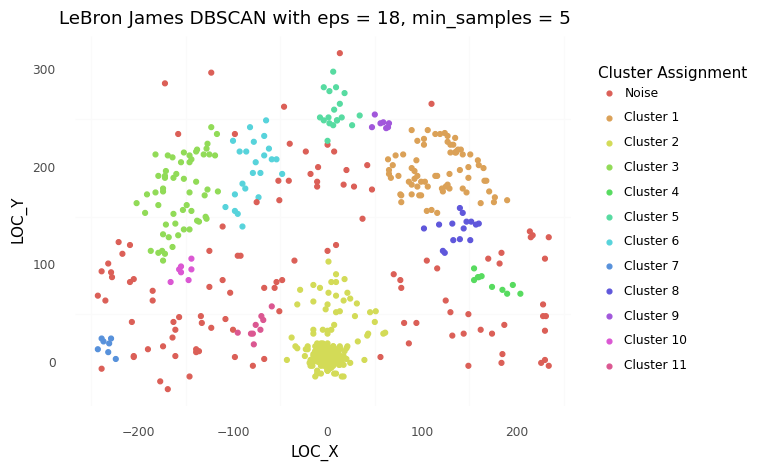

<ggplot: (326298944)>

In [192]:
#Lebron 09-10 season by quarter
season0910 = shot_df.loc[(shot_df["GAME_DATE"] > 20091001) & (shot_df["GAME_DATE"] < 20100801)]
lebron1 = season0910.loc[season0910['PLAYER_NAME'] == "LeBron James"]
lebron_made1 = lebron1.loc[lebron1["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(lebron_made1[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

lebron_made1["assignments"] = db1.labels_

(ggplot(lebron_made1, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "LeBron James DBSCAN with eps = 18, min_samples = 5"))

In [193]:
# grab only clustered data points
lebron_clustered1 = lebron_made1.loc[(lebron_made1.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(lebron_clustered1[["LOC_X","LOC_Y"]], lebron_clustered1["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(lebron_made1[["LOC_X","LOC_Y"]], lebron_made1["assignments"]))

Clustered silhouette score:  0.6276748563026996
Overall silhouette score:  0.43251660507951817


In LeBron James's 2009-10 season his shot-chart follows a similar pattern to his in the 2008-09 season. He primarily shoots from under the basket but he also shoots 3-pointers from the top of the arc. He does not shoot often from the corner and from mid-range. The clustered silhouette score is 0.6277 and the overall is 0.4325. The silhouette scores are very similar to his previous because the clusters are very similar as well. In the 2009-10 season the silhouette score is slightly lower due to LeBron taking shots from areas he did not as often before.

#### Kevin Durant 2020-21 Season

I was unable to find data for the MVP winners between the 2010-11 season and the 2013-14 season. During this timespan Derrick Rose won in 2010-11 with the Chicago Bulls, LeBron James won in 2011-12 and 2012-13 with the Miami Heat, and Kevin Durant winning in 2013-14 with the Oklahoma City Thunder. However, Kevin Durant is still a top player in the NBA and is one of the most dangerous offensive players in the league. That is why I will look at his shot-chart for the 2020-21 season where he averaged 26.9 points for the Brooklyn Nets.

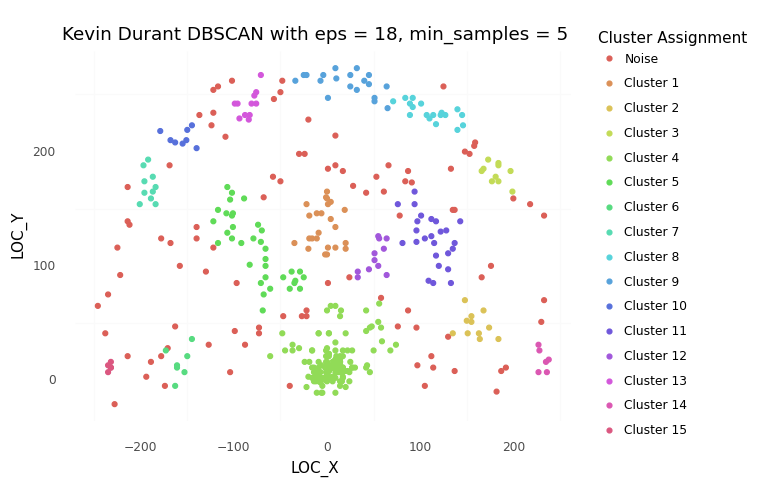

<ggplot: (-9223372036532056425)>

In [194]:
#Kevin Durant 2020-21 season by quarter
season1617 = shot_df.loc[(shot_df["GAME_DATE"] > 20161001) & (shot_df["GAME_DATE"] < 20170801)]
durant = season1617.loc[season1617['PLAYER_NAME'] == "Kevin Durant"]
durant_made = durant.loc[durant["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(durant_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

durant_made["assignments"] = db1.labels_

(ggplot(durant_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Kevin Durant DBSCAN with eps = 18, min_samples = 5"))

In [195]:
# grab only clustered data points
durant_clustered = durant_made.loc[(durant_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(durant_clustered[["LOC_X","LOC_Y"]], durant_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(durant_made[["LOC_X","LOC_Y"]], durant_made["assignments"]))

Clustered silhouette score:  0.6719758823657567
Overall silhouette score:  0.42886827409676653


Kevin Durant is a dangerous scorer from anywhere on the court as one can see from the multiple clusters. The most dense clusters are around the basket, the middle of the 3-point line and shots around the free-throw line. He also has clusters in both corners of the court which emphasizes how he can make a wide variety of shots. The clustered and overall silhouette score is 0.6720 and 0.4289 respectively. The model is effective at identifying the areas where Durant took most of shots and one can see he is a 3-level scorer. He is able to score from beyond the 3-point line, the mid-range area around the free-throw line where cluster 1, cluster 10 and cluster 5 are located, and near the basket. 

#### Stephen Curry 2014-15 Season

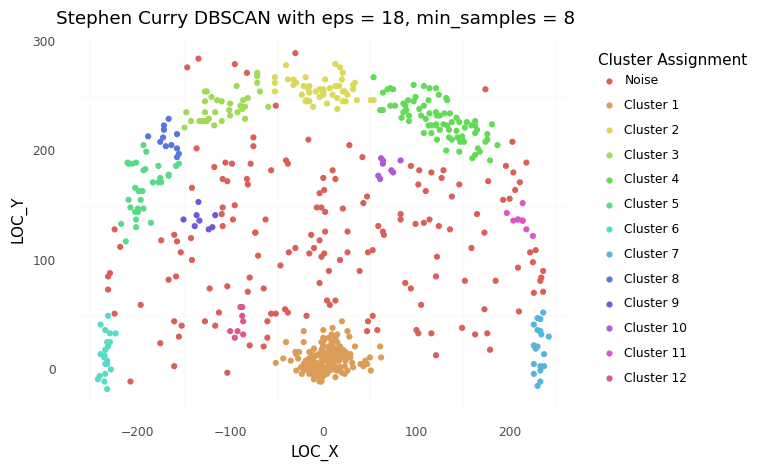

<ggplot: (321833792)>

In [196]:
#Stephen Curry 14-15 season by quarter
season1415 = shot_df.loc[(shot_df["GAME_DATE"] > 20141001) & (shot_df["GAME_DATE"] < 20150801)]
curry = season1415.loc[season1415['PLAYER_NAME'] == "Stephen Curry"]
curry_made = curry.loc[curry["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 8).fit(curry_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

curry_made["assignments"] = db1.labels_

(ggplot(curry_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Stephen Curry DBSCAN with eps = 18, min_samples = 8"))

In [197]:
# grab only clustered data points
curry_clustered = curry_made.loc[(curry_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(curry_clustered[["LOC_X","LOC_Y"]], curry_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(curry_made[["LOC_X","LOC_Y"]], curry_made["assignments"]))

Clustered silhouette score:  0.6229621985536867
Overall silhouette score:  0.3025650688578684


Above is Steph Curry's 2014-15 season where he led the Golden State Warriors to their first NBA championship since 1975 and won his first MVP. I used a larger min_samples for Curry's 2014-15 and 2015-16 season because the model clustered all of his shots around the 3-point line together. With a larger min_samples we are able to see specific areas that Curry likes to shoot the 3-point shot from. Curry takes a large amount of shots from beyond the 3-point arc which can be seen by the multiple clusters around the 3-point line. Curry is one of the players that is largely credited for changing the way basketball is played as more players start to shoot 3-pointers. He does not take a lot of shots from the mid-range on the right side however. The clusted silhouette score and overall is 0.1401 and 0.0280 respectively and is most likely this small due to the irregular shape of the clusters, especially the one around the 3-point line. The clusters located around the 3-point line are located next to each other and encompass the entire 3-point line which makes it less effective on this data set. 

#### Steph Curry 2015-16 Season

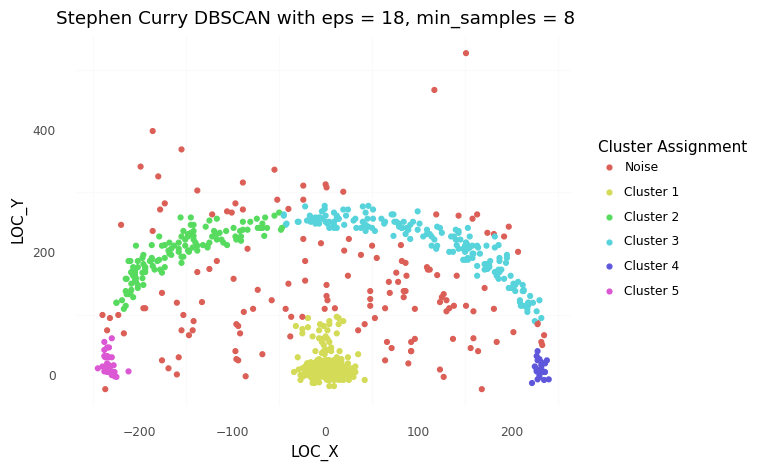

<ggplot: (323755093)>

In [198]:
#Steph Curry 15-16 season by quarter
season1516 = shot_df.loc[(shot_df["GAME_DATE"] > 20151001) & (shot_df["GAME_DATE"] < 20160801)]
curry2 = season1516.loc[season1516['PLAYER_NAME'] == "Stephen Curry"]
curry_made2 = curry2.loc[curry2["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 8).fit(curry_made2[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

curry_made2["assignments"] = db1.labels_

(ggplot(curry_made2, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Stephen Curry DBSCAN with eps = 18, min_samples = 8"))

In [199]:
# grab only clustered data points
curry_clustered2 = curry_made2.loc[(curry_made2.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(curry_clustered2[["LOC_X","LOC_Y"]], curry_clustered2["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(curry_made2[["LOC_X","LOC_Y"]], curry_made2["assignments"]))

Clustered silhouette score:  0.6738777876662464
Overall silhouette score:  0.4512006856565756


The DBSCAN model for Curry's 2015-16 can be seen above. Curry won the MVP unanimously for the first time in history as he had a historic season. The noise points located in the top right corner of the graph are shots that Curry made from around the halfway line. In this clustering algorithm, there are two very large clusters focused around the 3-point line which separate the right and left side. He also has a dense cluster of shots made around the bakset. These are most likely lay-ups under the basket. The clustered and overall silhouette score is 0.6739 and 0.4512 respectively. Unlike the previous season where Curry had clusters located in the 3-point, mid-range, and close area, in the 2015-16 season Curry's clusters were located around the 3-point line and under the basket. This illustrates how effective Curry was at making the 3-point shot. The overall silhouette score is not as high as the clustered because of all the noise points. 

#### Russell Westbrook 2016-17 Season

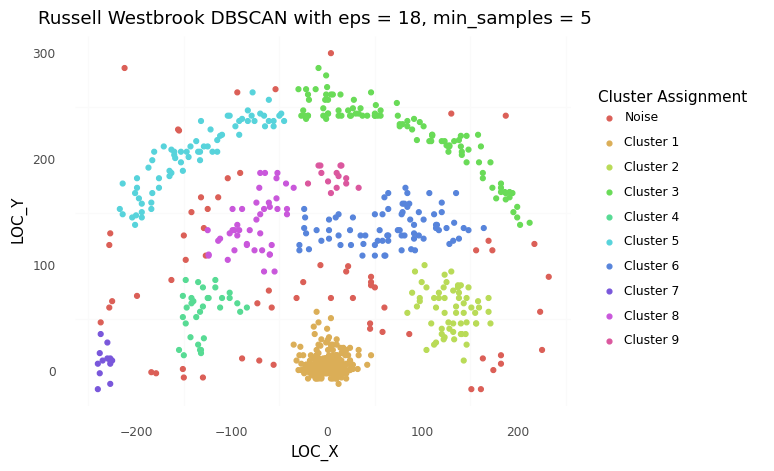

<ggplot: (322879692)>

In [200]:
#Westbrook MVP 2016-17 season by quarter
season1617 = shot_df.loc[(shot_df["GAME_DATE"] > 20161001) & (shot_df["GAME_DATE"] < 20170801)]
westbrook = season1617.loc[season1617['PLAYER_NAME'] == "Russell Westbrook"]
westbrook_made = westbrook.loc[westbrook["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(westbrook_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

westbrook_made["assignments"] = db1.labels_

(ggplot(westbrook_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Russell Westbrook DBSCAN with eps = 18, min_samples = 5"))

In [201]:
# grab only clustered data points
westbrook_clustered = westbrook_made.loc[(westbrook_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(westbrook_clustered[["LOC_X","LOC_Y"]], westbrook_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(westbrook_made[["LOC_X","LOC_Y"]], westbrook_made["assignments"]))

Clustered silhouette score:  0.5624368230432073
Overall silhouette score:  0.46846820484483004


Above is the shot-chart for Westbrook's model. Unlike the previous MVP's, westbrook takes a significant amount of shots from the mid-range area, in the restricted area, and 3-pointers from the top of the arc. The clustered silhouette score for Westbrook's model is 0.5624 while the overall is 0.4685. The silhouette scores are high which are illustrated in how the clusters are easily identifiable when looking at the graph. 

#### James Harden 2017-18 Season

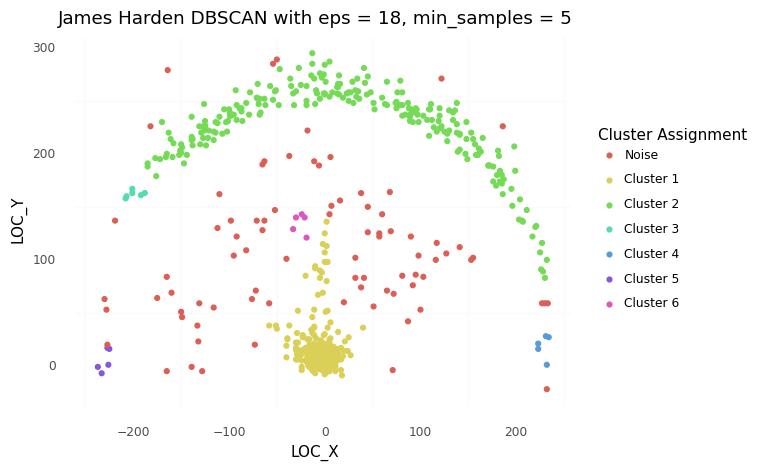

<ggplot: (323324308)>

In [202]:
#James Harden MVP 2017-18 season
season1718 = shot_df.loc[(shot_df["GAME_DATE"] > 20171001) & (shot_df["GAME_DATE"] < 20180801)]
harden = season1718.loc[season1718['PLAYER_NAME'] == "James Harden"]
harden_made = harden.loc[harden["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(harden_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

harden_made["assignments"] = db1.labels_

(ggplot(harden_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "James Harden DBSCAN with eps = 18, min_samples = 5"))

In [203]:
# grab only clustered data points
harden_clustered = harden_made.loc[(harden_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(harden_clustered[["LOC_X","LOC_Y"]], harden_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(harden_made[["LOC_X","LOC_Y"]], harden_made["assignments"]))

Clustered silhouette score:  0.42576532740274564
Overall silhouette score:  0.31131785375152754


James Harden's shot-chart from his 2017-18 season is also very unique as well. There are two significant clusters focused around the basket and around the 3-point line. Similar to Curry, Harden is able to free up space through dribbling moves and is very efficient at shooting from beyond the 3-point line. The clustered silhouette score is 0.4258 and the overall is 0.3113. The silhouette score does not accurately reflect how well the model did on the data. It clearly identifies two large clusters around the 3-point line and near the basket. It is clear that Harden rarely took shots from areas other than the ones clustered.

#### Giannis Antetokounmpo 2018-19 Season

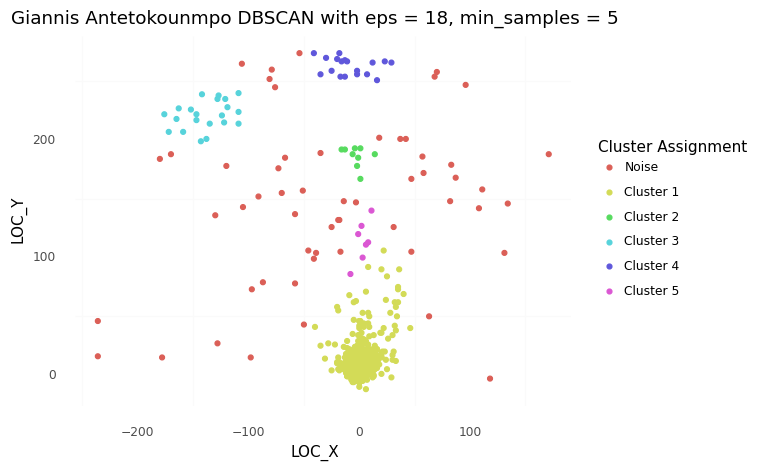

<ggplot: (325195240)>

In [204]:
#Giannis Antetokounmpo MVP 2018-19 season
season1819 = shot_df.loc[(shot_df["GAME_DATE"] > 20181001) & (shot_df["GAME_DATE"] < 20190801)]
giannis19 = season1819.loc[season1819['PLAYER_NAME'] == "Giannis Antetokounmpo"]
giannis19_made = giannis19.loc[giannis19["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(giannis19_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

giannis19_made["assignments"] = db1.labels_

(ggplot(giannis19_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Giannis Antetokounmpo DBSCAN with eps = 18, min_samples = 5"))

In [205]:
# grab only clustered data points
giannis_clustered = giannis19_made.loc[(giannis19_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(giannis_clustered[["LOC_X","LOC_Y"]], giannis_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(giannis19_made[["LOC_X","LOC_Y"]], giannis19_made["assignments"]))

Clustered silhouette score:  0.78677082955611
Overall silhouette score:  0.6876968715549385


Giannis's MVP season displayed how athletic he is as he dunked on nearly every play. This can be seen in the very dense cluster under the basket. He rarely took shots from anywhere else which can be seen by the smaller clusters and the noise points. The clustered silhouette score for the model on Giannis's shot-chart is 0.7878 and the overall is 0.6877. These are high silhouette scores which reflect the areas that Giannis likes to shoot from. The dense cluster near the basket illustrates how Giannis uses his athleticism to power his way to the basket to score.

#### Giannis Antetokounmpo 2019-20 Season

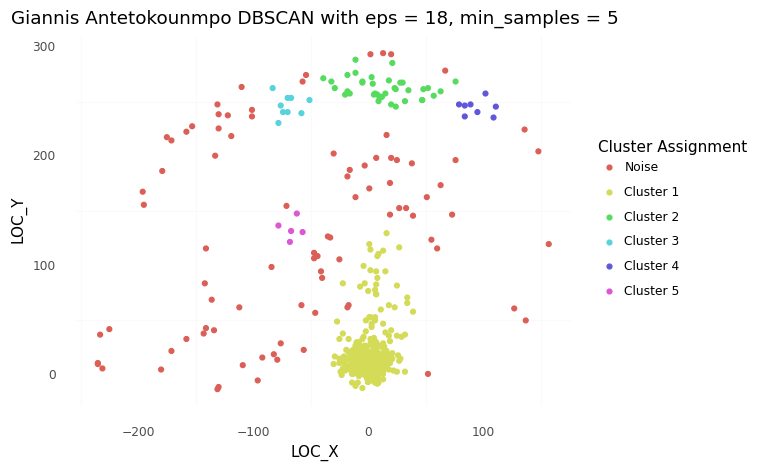

<ggplot: (-9223372036531448674)>

In [206]:
#Giannis Antetokounmpo MVP 2019-20 season
season1920 = shot_df.loc[(shot_df["GAME_DATE"] > 20191001) & (shot_df["GAME_DATE"] < 20200801)]
giannis20 = season1920.loc[season1920['PLAYER_NAME'] == "Giannis Antetokounmpo"]
giannis20_made = giannis20.loc[giannis20["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(giannis20_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

giannis20_made["assignments"] = db1.labels_

(ggplot(giannis20_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Giannis Antetokounmpo DBSCAN with eps = 18, min_samples = 5"))

In [207]:
# grab only clustered data points
giannis_clustered2 = giannis20_made.loc[(giannis20_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(giannis_clustered2[["LOC_X","LOC_Y"]], giannis_clustered2["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(giannis20_made[["LOC_X","LOC_Y"]], giannis20_made["assignments"]))

Clustered silhouette score:  0.7792026130720747
Overall silhouette score:  0.6045214217633054


In the 2019-20 season, Giannis's shot chart has developed and he has started to make more shots from around the court. He has become more efficient from beyond the 3-point arc and has scored a lot more than he did in the previous season. He has also started to make more shots from the mid-range area. The clustered silhouette score is 0.6386 and the overall silhouette score is 0.5506. The silhouette scores are lower for Giannis's 2019-20 season because he expanded his offensive capabilities and started shooting more from further out. This reflects the importance of the 3-point shot in the modern game. Despite winning the MVP in the 2018-19 season, Giannis still had to improve as teams started to force him to take shots from further out instead of letting him drive to the basket.

#### Nikola Jokic 2020-21 Season

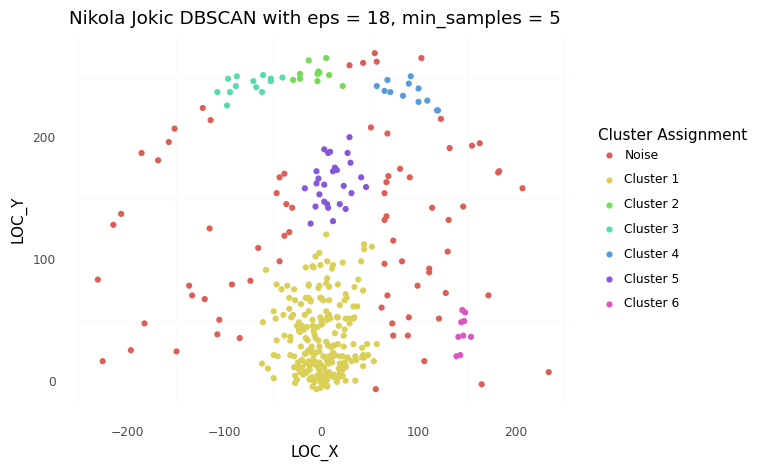

<ggplot: (-9223372036532047111)>

In [208]:
#Nikola Jokic MVP 2020-21 season
season2021 = shot_df.loc[(shot_df["GAME_DATE"] > 20201001) & (shot_df["GAME_DATE"] < 20210801)]
jokic = season2021.loc[season2021['PLAYER_NAME'] == "Nikola Jokic"]
jokic_made = jokic.loc[jokic["SHOT_MADE_FLAG"] == 1]

db1 = DBSCAN(eps = 18, min_samples = 5).fit(jokic_made[["LOC_X", "LOC_Y"]])

labsList = ["Noise"]
labsList = labsList  + ["Cluster " + str(i) for i in range(1,len(set(db1.labels_)))]

jokic_made["assignments"] = db1.labels_

(ggplot(jokic_made, aes(x = "LOC_X", y = "LOC_Y", color = "factor(assignments)")) +
 geom_point() +
 theme_minimal() +
 scale_color_discrete(name = "Cluster Assignment",
                      labels = labsList) +
theme(panel_grid_major = element_blank()) +
labs(title = "Nikola Jokic DBSCAN with eps = 18, min_samples = 5"))

In [209]:
# grab only clustered data points
jokic_clustered = jokic_made.loc[(jokic_made.assignments >= 0)]

print("Clustered silhouette score: ", silhouette_score(jokic_clustered[["LOC_X","LOC_Y"]], jokic_clustered["assignments"]))

# overall 
print("Overall silhouette score: ", silhouette_score(jokic_made[["LOC_X","LOC_Y"]], jokic_made["assignments"]))

Clustered silhouette score:  0.6203083384712763
Overall silhouette score:  0.4077599691657222


Lastly, Nikola Jokic's 2020-21 MVP season shows a large cluster around the basket and up to the free-throw line. There are other clusters around the mid-range and 3-point line but as a center, Jokic primarily shoots around the basket. The clustered silhouette score is 0.2703 and the overall is 0.1594. The silhouette scores are not as strong as it is for other models because of clusters such as cluster 1 which encompasses the area near the basket. 

### Conclusion

Overall, our model does well at predicting where a player is most likely to shoot from and this data can be valuable for opposing coaches as well as the player himself to develop his game and work on his weaknesses. Trends can be seen across the graphs when looking at each player's position. Players like Giannis Antetokounmpo, Nikola Jokic, and LeBron James mainly score the majority of their points around the basket. They do this by making use of their physical size and athleticism to get to the basket. In positions such as the small-forward position we see players such as Kevin Durant and Russell Westbrook who are versatile all across the court. Other players such as James Harden and Stephen Curry are dangerous from beyond the 3-point line and score a lot of points along this line. In the 2015-16 season where Curry won MVP unanimously, it is clear how efficient he is when shooting 3-points and how far he is able to shoot from.

## MIN'S PART

For data cleaning purposes, I used code from https://www.kaggle.com/noobiedatascientist/feature-selection-in-the-nba to orangize and make the data neater.

In [210]:
#Data Cleaning

#Lebron James
lebron.fillna(0, inplace=True) # Replace null values to zero

#Make all columns upper case
lebron.columns = [col.upper() for col in lebron.columns]

#Convert object data types to apporiate data types
lebron['RESULT'] = lebron['RESULT'].str[:1]
lebron['DATE'] = pd.to_datetime(lebron['DATE'])
lebron["MP"] = lebron["MP"].apply(lambda x: float(str(x).replace(":",".").split(",")[0].strip()))
lebron["AGE"] = lebron["AGE"].apply(lambda x: float(str(x).replace("-",".").split(",")[0].strip()))

#Change RESULT column to binary
win_loss = {'W': 1, 'L': 0}
lebron['RESULT'] = lebron['RESULT'].map(win_loss)

#Michael Jordan
jordan.fillna(0, inplace=True) # Replace null values to zero

#Make all columns upper case
jordan.columns = [col.upper() for col in jordan.columns]

#Convert object data types to apporiate data types
jordan['RESULT'] = jordan['RESULT'].str[:1]
jordan['DATE'] = pd.to_datetime(jordan['DATE'])
jordan["MP"] = jordan["MP"].apply(lambda x: float(str(x).replace(":",".").split(",")[0].strip()))
jordan["AGE"] = jordan["AGE"].apply(lambda x: float(str(x).replace("-",".").split(",")[0].strip()))

#Change RESULT column to binary
jordan['RESULT'] = jordan['RESULT'].map(win_loss)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#All player data
details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)
details.fillna(0, inplace=True)
details = details.drop_duplicates(subset=["GAME_ID", "PLAYER_NAME"])
details['WON_GAME'] = 0

games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)
games.fillna(0, inplace=True)

Question 4: How do basketball stats relate to one another?

With the many statistics of basketball, we will try to narrow them down using PCA with a factor analysis approach. We will be able to see the interesting and unique relationships each stat has with one another. The aim of this PCA is to reduce 20 stats into a few components and try to see if these components mean anything significant.


I used this aggregate function (below) from the referenced notebook so I can easily access seasonal data and analyze the principle components based on the season. This function returns the sum of all the stats for a given season. This will allow PCA to look at the total variance in a specific season with the sums.


In [211]:
def get_season_data(season):
    
    temp = details.loc[details.GAME_ID.isin(games.loc[games.SEASON == season, 'GAME_ID'])]
    temp = temp.loc[~temp['PLAY_TIME'].isnull()]
    agg_df = temp.groupby(['PLAYER_ID', 'PLAYER_NAME', 'PLAYER_NAME_SHORT'])[['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','PLAY_TIME']].sum().reset_index()
    agg_df = agg_df.loc[agg_df['PLAY_TIME'] >= 1500].reset_index(drop = True)
    st_agg_df = StandardScaler().fit_transform(agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']))
    return(agg_df, st_agg_df)

#reference
#https://www.kaggle.com/noobiedatascientist/feature-selection-in-the-nba

In [212]:
#PCA
pca = PCA(n_components = 3)
agg_df, st_agg_df = get_season_data(2020)
pcomp = pca.fit_transform(st_agg_df)

df = pd.DataFrame(pca.components_, 
             index = ['PC 1', 'PC 2', 'PC 3'],
             columns = agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']).columns).round(2)
df

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
PC 1,0.34,0.32,0.16,0.09,0.10,0.03,0.31,0.31,0.30,0.11,0.24,0.21,0.23,0.13,0.08,0.31,0.16,0.34,0.15
PC 2,-0.06,-0.16,0.27,-0.36,-0.37,-0.32,-0.05,0.00,-0.06,0.41,0.26,0.32,-0.13,-0.05,0.34,-0.07,0.19,-0.11,0.03
PC 3,-0.00,0.00,-0.31,-0.35,-0.30,-0.41,0.25,0.26,0.08,-0.05,-0.15,-0.13,0.24,-0.00,-0.17,0.21,-0.27,0.01,-0.37


Answer to Question 4:

Looking at this PCs table that I got from: https://www.kaggle.com/noobiedatascientist/feature-selection-in-the-nba, we can see where the varibles rank in each of principle components. Varibles with high scores in the same component are more related to each other than varibles that scored lowered in that component.

The first principle component are the offensive stats like FGM, PTS, and FG/FT %. The second principle component are the defensive stats like rebounds, blocks, and personal fouls.

PCA was able to pick apart which varibles are more offesive and which ones are more defensive. We can see which stats are related more to one another.


In [213]:
d = details[['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']]

z1 = StandardScaler()
d = z1.fit_transform(d)

pca_nba = PCA()
pca_nba.fit_transform(d)

pcaDF = pd.DataFrame({'explained': pca_nba.explained_variance_ratio_, 'pc': range(1,20), "cum_var": pca_nba.explained_variance_ratio_.cumsum()})


pcaDF

,explained,pc,cum_var
0,4.056292e-01,1,0.405629
1,1.270822e-01,2,0.532711
2,7.806606e-02,3,0.610778
3,5.638058e-02,4,0.667158
4,5.143196e-02,5,0.718590
5,4.339130e-02,6,0.761981
6,3.913747e-02,7,0.801119
7,3.652173e-02,8,0.837641
8,3.391404e-02,9,0.871555
9,2.984699e-02,10,0.901402


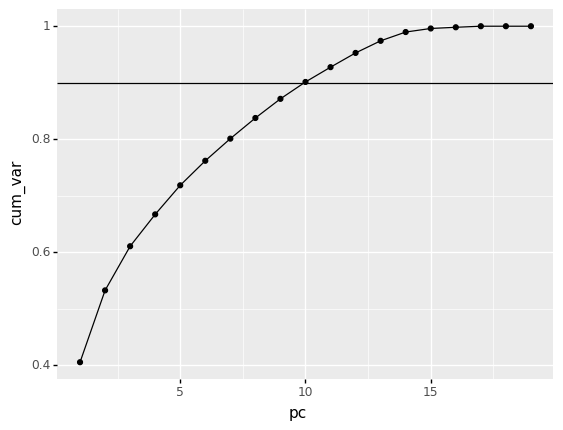

<ggplot: (-9223372036517395852)>

In [214]:
(ggplot(pcaDF, aes(x = 'pc', y = 'cum_var')) + geom_line() + geom_point() + geom_hline(yintercept = 0.90))

Even thought PCA was able to reduce the amount of varibles from 18 to 7 to reach at least 80% of the explained variance, applying PCA to this dataset does not really help us, and this explains the nature of basketball. The game is very fast paced and with momentum and pressure move from team to team each play clock. From the beginning of the game, every point matters. Team are able to capitalize on many aspects of the game, like rebounds, fouls, fast breaks, mistakes. And we can see that with the graph as a good amount of the variables in this dataset explain the variance and not just a few like PTS and FG%. 

Question 5: Which stats factor more into wins?

We will be answering this question by comparing Michael Jordan and LeBron James. We will look at the coefficients of a logistic regression that predicts the outcome of the game to answer this question. First, let's look at their overall stats.

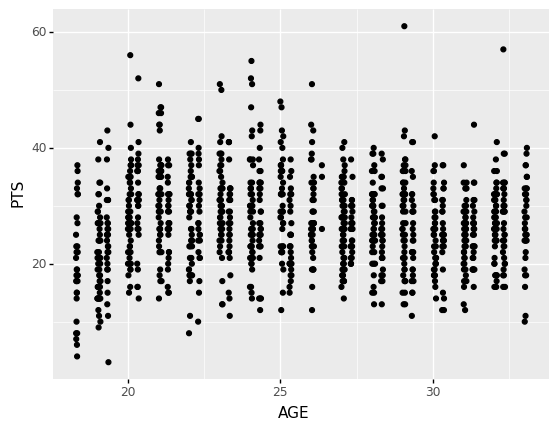

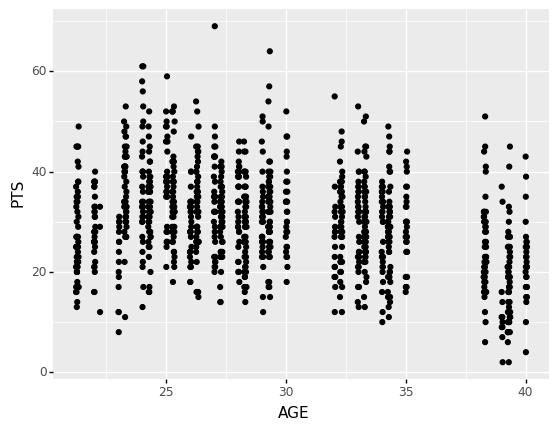

In [215]:
print(ggplot(lebron, aes(x = "AGE", y = "PTS")) + geom_point(),
ggplot(jordan, aes(x = "AGE", y = "PTS")) + geom_point())


We can see that as Jordan gets older, his points per game has declined whereas lebron has stayed consistant and his performance. Lebron also has a couple more seasons left in him.

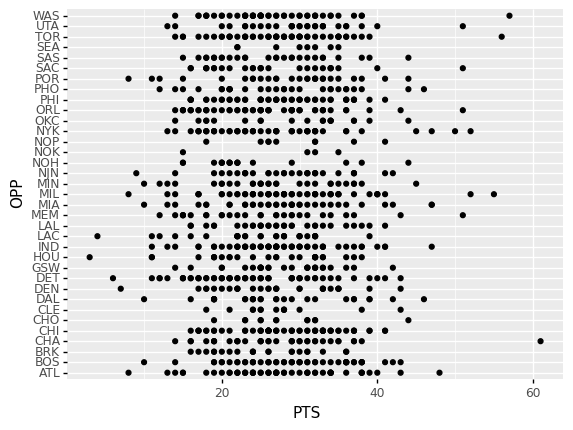

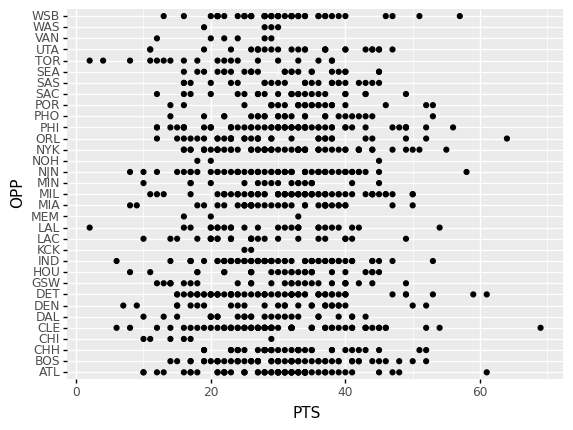

In [216]:
print(ggplot(lebron, aes(x = "PTS", y = "OPP")) + geom_point(),
ggplot(jordan, aes(x = "PTS", y = "OPP")) + geom_point())

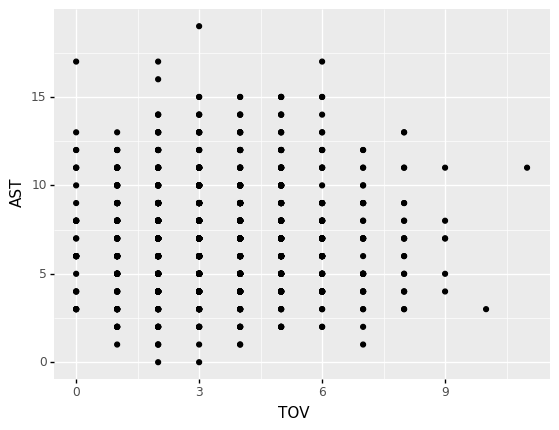

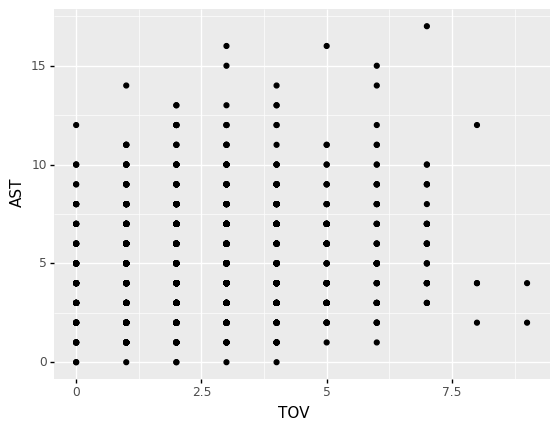

In [217]:
print(ggplot(lebron, aes(x = "TOV", y = "AST")) + geom_point(),
ggplot(jordan, aes(x = "TOV", y = "AST")) + geom_point())

Based on the the amount of wins per team and ast/tov plot, we can see that Lebron and Jordan are very similiar in terms of performance. They score around the same amount of points no matter what team they play and their ball handling and playing making skills are similar with LeBron having more turnovers than Jordan based on the ast/tov plot.

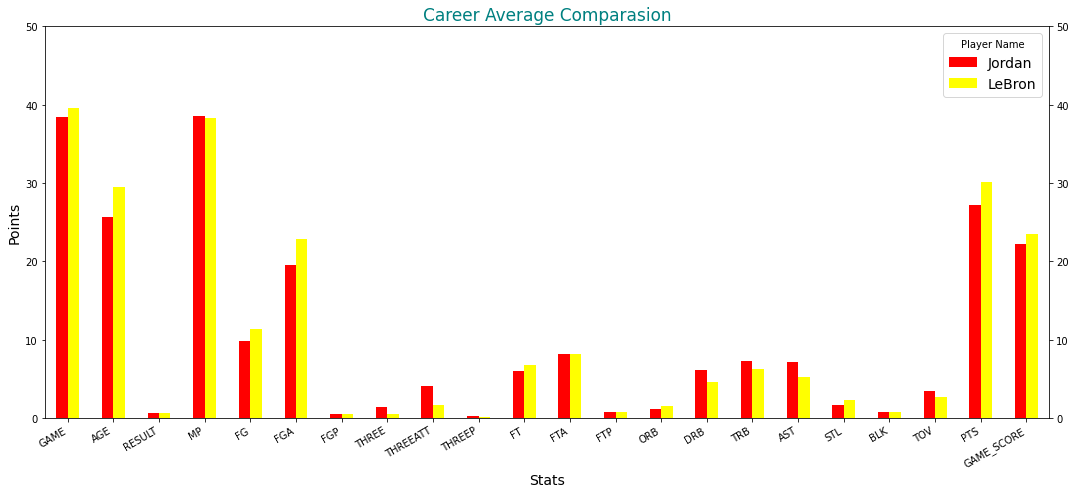

In [219]:
le = lebron.mean() # get averages for all stats throught out career 
jor = jordan.mean()

lebron_mean = pd.DataFrame(le).transpose() #change dtypes to objects
jordan_mean = pd.DataFrame(jor).transpose()

dataset = pd.DataFrame(pd.concat([lebron_mean, jordan_mean], ignore_index=True)) #combine the two dataframes
dataset = dataset.rename(index={0:'Jordan', 1:'LeBron'}) #rename the rows
dataset.drop('MINUS_PLUS', axis=1, inplace=True) # drop "MINUS_PLUS" variable because jordan data set doesn't have it 

fig, ax = plt.subplots(figsize=(18,8)) #create plot and dimensions 
dataset.transpose().plot(ax=ax, kind='bar', colormap='autumn') #plot

ax.set_title("Career Average Comparasion", fontsize=17, color='teal') #title
ax.set_xlabel("Stats", fontsize=14) #X axis label
ax.set_ylabel("Points", fontsize=14) # Y axis label

ax.set_ylim(0, 50)#limit for y 
ax.legend(fontsize=14, title='Player Name') #add key/legend
ax.tick_params('y', direction='out', left=True, right=True, labelright=True, labelleft=True)#left to right reading

fig.autofmt_xdate()

We can look at all these stats and make an argument about who's a better basketball player but what I want to do is apply machine learning to this dataset and see if the machine can pick up on any patterns in Jordan's or LeBron's game. 

We will use a logistic regression to see if the machine can predict whether or not Jordan or LeBron won that game based on their end stat line for that game. We will be using all the continuous varibles icluding age and minutes played but not minus/plus because the jordan dataset doesn't have values for that column. I could have added dummy variables so I can use "OPP" as a feature but there are 30 different teams...

I created seperate models for Jordan and Lebron.

[0.5833333333333334, 0.6296296296296297, 0.6728971962616822, 0.7102803738317757, 0.7850467289719626, 0.7476635514018691, 0.794392523364486, 0.7102803738317757, 0.7102803738317757, 0.45794392523364486]


0.6801748009691935

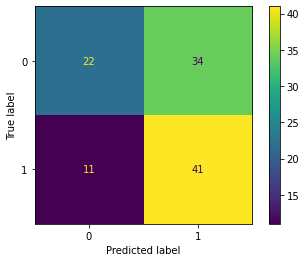

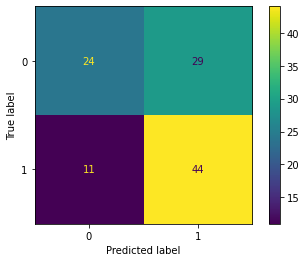

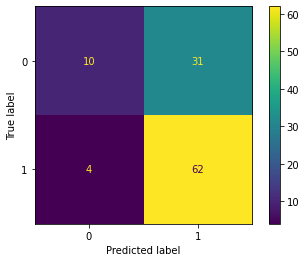

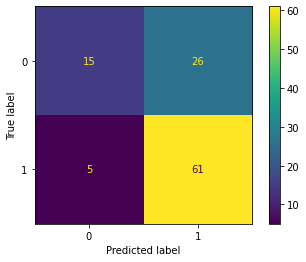

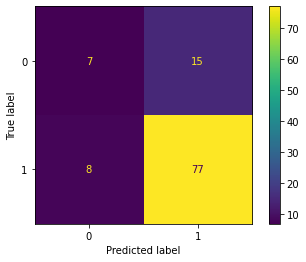

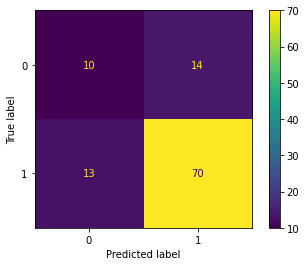

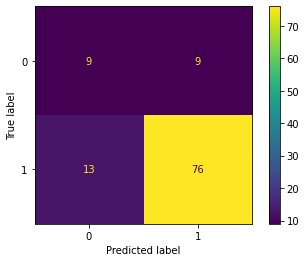

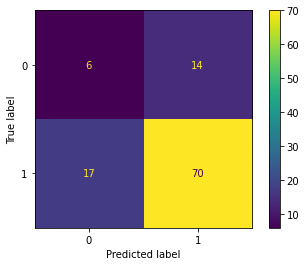

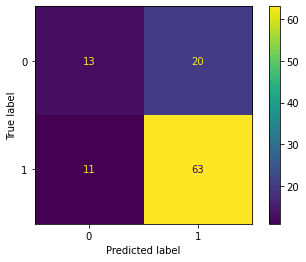

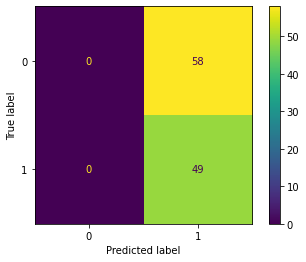

In [220]:
#Logistic Regression for Jordan

# variables = ['GAME', 'DATE', 'AGE', 'TEAM', 'OPP', 'RESULT', 'MP', 'FG', 'FGA','FGP', 'THREE', 'THREEATT', 'THREEP', 'FT', 'FTA', 'FTP', 'ORB', 'DRB','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'GAME_SCORE', 'MINUS_PLUS']

predictors = ['AGE','MP', 'FG', 'FGA','FGP', 'THREE', 'THREEATT', 'THREEP', 'FT', 'FTA', 'FTP', 'ORB', 'DRB','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'GAME_SCORE']

x = jordan[predictors]
y = jordan['RESULT']

#K Fold
kf = KFold(n_splits = 10)
kf.split(x)

lr = LogisticRegression() #create model

acc = []

for train_indices, test_indices in kf.split(x):
    # Get your train/test for this fold
    X_train = x.iloc[train_indices]
    X_test  = x.iloc[test_indices]
    y_train = y[train_indices]
    y_test  = y[test_indices]
    
    #z-score
    zscore = StandardScaler()
    X_train = zscore.fit_transform(X_train)
    X_test = zscore.transform(X_test)
    
    # model
    model = lr.fit(X_train, y_train)
    n = model.predict(X_test)
    
    # record accuracy
    acc.append(accuracy_score(y_test, n))
    plot_confusion_matrix(model, X_test, y_test)
    
#print overall acc
print(acc)
np.mean(acc)


In [221]:
coef = pd.DataFrame({'Coefs': lr.coef_[0], 'Names': predictors})

coef['Odds'] = np.exp(coef['Coefs'])

coef

,Coefs,Names,Odds
0,0.762150,AGE,2.142879
1,-0.194035,MP,0.823629
2,-0.510495,FG,0.600199
3,-0.037268,FGA,0.963418
4,0.647943,FGP,1.911605
5,0.638659,THREE,1.893940
6,-0.453637,THREEATT,0.635313
7,-0.229216,THREEP,0.795157
8,0.323538,FT,1.382008
9,-0.259944,FTA,0.771094


[0.6228070175438597, 0.631578947368421, 0.6548672566371682, 0.7610619469026548, 0.7964601769911505, 0.7876106194690266, 0.7787610619469026, 0.7433628318584071, 0.8053097345132744, 0.6017699115044248]


0.7183589504735289

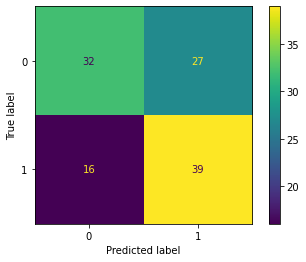

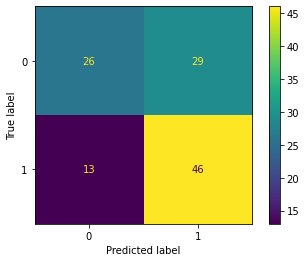

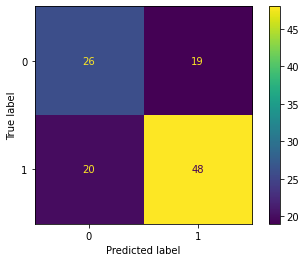

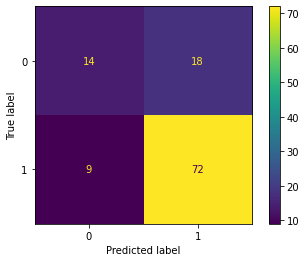

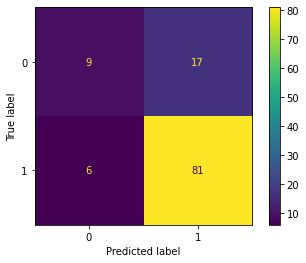

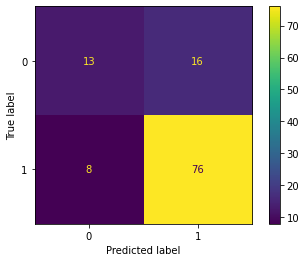

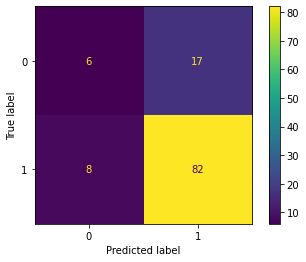

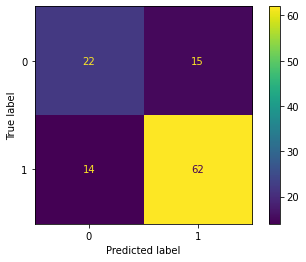

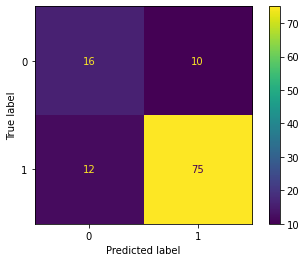

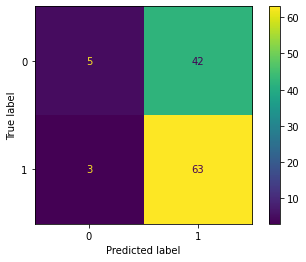

In [222]:
#Logistic Regression for Lebron

x2 = lebron[predictors]
y2 = lebron['RESULT']

# x = pd.get_dummies(x)

#K Fold
kf2 = KFold(n_splits = 10)
kf2.split(x2)

lr2 = LogisticRegression() #create model

acc2 = []

for train_indices, test_indices in kf2.split(x2):
    # Get your train/test for this fold
    X_train = x2.iloc[train_indices]
    X_test  = x2.iloc[test_indices]
    y_train = y2[train_indices]
    y_test  = y2[test_indices]
    
    #z-score
    zscore = StandardScaler()
    X_train = zscore.fit_transform(X_train)
    X_test = zscore.transform(X_test)
    
    # model
    model = lr2.fit(X_train, y_train)
    n = model.predict(X_test)
    
    # record accuracy
    acc2.append(accuracy_score(y_test, n))
    plot_confusion_matrix(model, X_test, y_test)
    
#print overall acc
print(acc2)
np.mean(acc2)

In [223]:
coef2 = pd.DataFrame({'Coefs': lr2.coef_[0], 'Names': predictors})

coef2['Odds'] = np.exp(coef2['Coefs'])

coef2

,Coefs,Names,Odds
0,0.116786,AGE,1.123879
1,-0.655624,MP,0.519118
2,-0.197099,FG,0.821109
3,0.027729,FGA,1.028117
4,0.504078,FGP,1.655458
5,0.123227,THREE,1.131142
6,-0.398312,THREEATT,0.671453
7,-0.039222,THREEP,0.961538
8,0.263732,FT,1.301780
9,-0.120245,FTA,0.886703


Answer to Question 5:

Based on the accuracy score and confusion matrices, the model performed pretty well. I used KFold over TTS for the increase in accuracy. I used 10 folds and we can see very similiar patterns for both Jordan and LeBron's matrices. 

The first couple folds showed pretty inaccurate results with no pattern in the prediciton. When we get to the middle, the model is reaching almost 80% accuracy. Then, in the last couple folds, we see that the model is consistently predicting that they won the game when they actually lost the game. So a false positive.

But what is most important about this regression is the coefficients. This shows us how much weight each variable has when the model is calculating the prediciton. We can see that the age variable is weighted more for Jordan than LeBron. Going back to the ggplots, LeBron has stayed more consistant than Jordan as they age in terms of points in a game. The logistic regression was able to pick up on that and we can see the model weighting age more for Jordan when deciding if he won or not.

Looking at the rest of the stats, we can see that in order for Jordan to win games, the model relied more on Jordan FG% and 3PT whereas LeBron had heavier weights in AST and REB. 

We can interpret this as, the model factors in FG% and 3PT more than other stats to predict if Jordan won or not whereas for LeBron, the model factors AST and RED more. This also explains the type of players they were. Jordan was high precentage scoring machine whereas LeBron was more of a playmaker who got his team more involved.

So to answer the question, the stats that factor more into wins are based on what type of basketball player they are and their strengths. LeBron wins more when he gets his team involved and Jordan wins when he scores a lot. You have to look at the strengthen of the player and if the player's main stats are doing well, they will more likey win the game.



Now, we will apply PCA to LeBron and Jordan's stats to see if we can increase accuracy or have some meaningful interpretations.

In [224]:
#Apply PCA
X = jordan[['AGE','MP', 'FG', 'FGA','FGP', 'THREE', 'THREEATT', 'THREEP', 'FT', 'FTA', 'FTP', 'ORB', 'DRB','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS','GAME_SCORE']]
X2 = lebron[['AGE','MP', 'FG', 'FGA','FGP', 'THREE', 'THREEATT', 'THREEP', 'FT', 'FTA', 'FTP', 'ORB', 'DRB','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS','GAME_SCORE']]

z = StandardScaler()
X = z.fit_transform(X)
X2 = z.fit_transform(X2)

pca_jordan = PCA()
pca_jordan.fit(X)

pca_lebron = PCA()
pca_lebron.fit(X2)


PCA()

In [225]:
pcaDF_jordan = pd.DataFrame({'explained': pca_jordan.explained_variance_ratio_, 'pc': range(1,21), "cum_var": pca_jordan.explained_variance_ratio_.cumsum()})

pcaDF_lebron = pd.DataFrame({'explained': pca_lebron.explained_variance_ratio_, 'pc': range(1,21), "cum_var": pca_lebron.explained_variance_ratio_.cumsum()})

pcaDF_lebron

,explained,pc,cum_var
0,2.424438e-01,1,0.242444
1,1.219233e-01,2,0.364367
2,1.052942e-01,3,0.469661
3,8.779845e-02,4,0.557460
4,7.200966e-02,5,0.629469
5,5.501569e-02,6,0.684485
6,5.454721e-02,7,0.739032
7,4.929181e-02,8,0.788324
8,4.604764e-02,9,0.834372
9,4.373286e-02,10,0.878105


In [226]:
#Apply PCA
pca3 = pca_jordan.transform(X)
pca3 = pd.DataFrame(pca3[:, 0:3])

pca7 = pca_jordan.transform(X)
pca7 = pd.DataFrame(pca7[:, 0:7])

pca10 = pca_jordan.transform(X)
pca10 = pd.DataFrame(pca10[:, 0:10])


In [227]:
log = LogisticRegression()
log.fit(X, jordan['RESULT'])
print("all data: ", log.score(X, jordan['RESULT']))

log2 = LogisticRegression()
log2.fit(pca10, jordan['RESULT'])
print("10 PCs: ", log2.score(pca10, jordan['RESULT']))

log3 = LogisticRegression()
log3.fit(pca7, jordan['RESULT'])
print("7 PCs: ", log3.score(pca7, jordan['RESULT']))

log4 = LogisticRegression()
log4.fit(pca3, jordan['RESULT'])
print("3 PCs: ", log4.score(pca3, jordan['RESULT']))



all data:  0.7005597014925373
10 PCs:  0.6949626865671642
7 PCs:  0.6958955223880597
3 PCs:  0.667910447761194


There is no increase in accuracy when we apply PCA. Applying PCA to this dataset doesn't really help and this explains the nature of basketball. The game is very fast paced and with momentum and pressure move from team to team each play clock. From the beginning of the game, every point matters. Team are able to capitalize on many aspects of the game, like rebounds, fouls, fast breaks, mistakes to score points. And we can see that with the graph as a good amount of the variables in this dataset explain the variance and not just a few like PTS and FG%.

Q6. Who will reign the NBA after LeBron?

I wanted to take Giannis, Anthony Davis, and Kevin Durant's stats for the logistic regression I did on Lebron and Jordan to see which stats factor more for that player and if it's similiar to LeBron or Jordan's. But due to columns types being different from lebrons and jordans columns, long runtimes, and inconsistent datasets, I had to abandon this part of the project and answer the question in a regualr stats vs stats comparison. 

Below is my code that didn't wokr and I sent Chelsea a picture of the nested for loop I had running for 30+ hours.

In [228]:
bron = details[details["PLAYER_NAME"] == "LeBron James"]
bron.drop(["TEAM_ID", "TEAM_CITY", "PLAYER_ID", "COMMENT"], axis=1, inplace=True)
games_date = games[["GAME_DATE_EST", "GAME_ID", "SEASON"]]
stats = bron.merge(games_date, on="GAME_ID", how="left")
seasonal_stats_lbj = stats.groupby("SEASON").sum()/stats.groupby("SEASON").count()

giannis = details[details["PLAYER_NAME"] == "Giannis Antetokounmpo"]
giannis.drop(["TEAM_ID", "TEAM_CITY", "PLAYER_ID", "COMMENT"], axis=1, inplace=True)
games_date2 = games[["GAME_DATE_EST", "GAME_ID", "SEASON"]]
stats2 = giannis.merge(games_date, on="GAME_ID", how="left")
seasonal_stats_giannis = stats2.groupby("SEASON").sum()/stats2.groupby("SEASON").count()

ad = details[details["PLAYER_NAME"] == "Anthony Davis"]
ad.drop(["TEAM_ID", "TEAM_CITY", "PLAYER_ID", "COMMENT"], axis=1, inplace=True)
games_date4 = games[["GAME_DATE_EST", "GAME_ID", "SEASON"]]
stats4 = ad.merge(games_date4, on="GAME_ID", how="left")
seasonal_stats_ad = stats4.groupby("SEASON").sum()/stats4.groupby("SEASON").count()

kd = details[details["PLAYER_NAME"] == "Kevin Durant"]
kd.drop(["TEAM_ID", "TEAM_CITY", "PLAYER_ID", "COMMENT"], axis=1, inplace=True)
games_date5 = games[["GAME_DATE_EST", "GAME_ID", "SEASON"]]
stats5 = kd.merge(games_date5, on="GAME_ID", how="left")
seasonal_stats_kd = stats5.groupby("SEASON").sum()/stats5.groupby("SEASON").count()


In [229]:
# I get an error when I run this 

# giannis['RESULT'] = giannis['RESULT'].str[:1]
# giannis['DATE'] = pd.to_datetime(giannis['DATE'])
# giannis["MP"] = giannis["MP"].apply(lambda x: float(str(x).replace(":",".").split(",")[0].strip()))
# giannis["AGE"] = giannis["AGE"].apply(lambda x: float(str(x).replace("-",".").split(",")[0].strip()))


# #Change RESULT column to binary
# win_loss = {'W': 1, 'L': 0}
# giannis['RESULT'] = giannis['RESULT'].map(win_loss)


I sent Chelsea a slack message for help but didn't get a reply so becuase I had to change gears and start over last minute (this happened Sunday), we will be comparing Giannis and KD to Lebron and the rest of the league.

Question 6: Who will reign the NBA after LeBron?

I didn't want to show some boring ggplot that just compared the averages of potental players so I used this radar plot I got from https://www.kaggle.com/nathanlauga/nba-games-eda-let-s-dive-into-the-data to show a more visually appealing graph that can be interpreted meaningfully. I also was running really low on time and needed something with substance to finish this project.

I copied the needed functions and code and tweaked it to so I can look at Giannis and Kevin Durant.

I compared them to LeBron as well as the league averages.

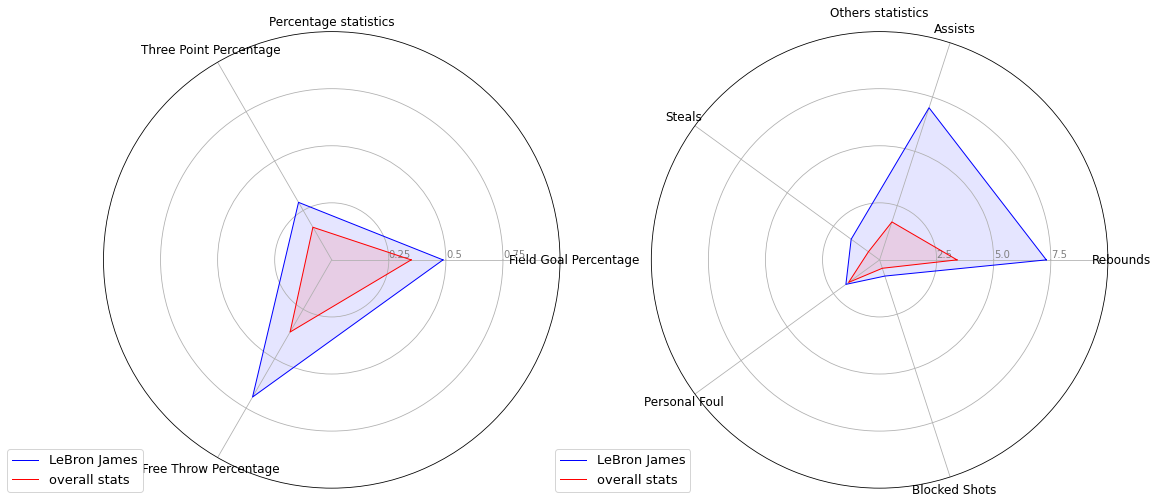

In [240]:
stats_cols = {
    'FGM':'Field Goals Made',
    'FGA':'Field Goals Attempted',
    'FG_PCT':'Field Goal Percentage',
    'FG3M':'Three Pointers Made',
    'FG3A':'Three Pointers Attempted',
    'FG3_PCT':'Three Point Percentage',
    'FTM':'Free Throws Made',
    'FTA':'Free Throws Attempted',
    'FT_PCT':'Free Throw Percentage',
    'OREB':'Offensive Rebounds',
    'DREB':'Defensive Rebounds',
    'REB':'Rebounds',
    'AST':'Assists',
    'TO':'Turnovers',
    'STL':'Steals',
    'BLK':'Blocked Shots',
    'PF':'Personal Foul',
    'PTS':'Points',
    'PLUS_MINUS':'Plus-Minus'
}

def agg_on_columns(df, agg_var, operation=['mean']):
    return df[agg_var].agg(operation)

# Remove players that didn't played at a game
df_tmp = details[~details['MIN'].isna()]

del df_tmp['MIN']

# Define key statistics columns, one for percentage variable and one for other important statistics
prct_var = ['FG_PCT', 'FG3_PCT', 'FT_PCT']
other_var = ['REB', 'AST', 'STL', 'PF', 'BLK'] 

# Create a specific dataset for LeBron James
lebron_james_df = df_tmp[df_tmp['PLAYER_NAME'] == 'LeBron James']

overall_agg_prct = agg_on_columns(df=df_tmp, agg_var=prct_var, operation=['mean'])
overall_agg_other = agg_on_columns(df=df_tmp, agg_var=other_var, operation=['mean'])

lebron_james_stats_prct = agg_on_columns(df=lebron_james_df, agg_var=prct_var, operation=['mean'])
lebron_james_stats_other = agg_on_columns(df=lebron_james_df, agg_var=other_var, operation=['mean'])

stats_prct = pd.concat([lebron_james_stats_prct, overall_agg_prct]) 
stats_other = pd.concat([lebron_james_stats_other, overall_agg_other]) 

stats_prct.index = ['LeBron James', 'overall stats']
stats_other.index = ['LeBron James', 'overall stats']

def rename_df(df, col_dict):
    cols = df.columns
    new_cols = [(col_dict[c] if c in col_dict else c) for c in cols]
    df.columns = new_cols
    return df

stats_prct = rename_df(stats_prct, col_dict=stats_cols)
stats_other = rename_df(stats_other, col_dict=stats_cols)

def radar_plot(ax, df, max_val=1):
    # number of variable
    categories=list(df)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    yticks = [max_val*i/4 for i in range(1,4)]
    plt.yticks(yticks, [str(e) for e in yticks], color="grey", size=10)
    plt.ylim(0,max_val)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    colors = ['b','r','g']
    for i in range(len(df)):
        values = df.values[i].flatten().tolist()
        values += values[:1]
        color = colors[i]

        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid', color=color, label=df.index[i])

        # Fill area
        ax.fill(angles, values, color, alpha=0.1)
     
    # Add legend
    plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
    
fig, ax = plt.subplots(figsize=(18, 9))

ax = plt.subplot(121, polar=True)
ax.set_title('Percentage statistics')
radar_plot(ax=ax, df=stats_prct, max_val=1)

ax = plt.subplot(122, polar=True)
ax.set_title('Others statistics')
radar_plot(ax=ax, df=stats_other, max_val=10)

plt.show()

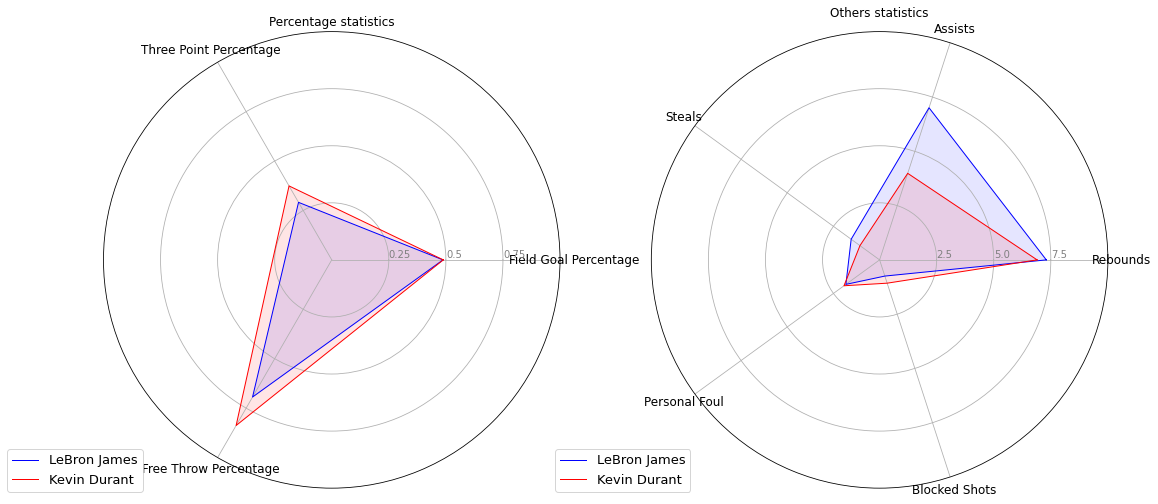

In [241]:
player_one = 'LeBron James'
player_two = 'Kevin Durant'

stats_prct, stats_other = get_players_stats(player_one=player_one, player_two=player_two)

show_player_stats_comparison(stats_prct, stats_other)

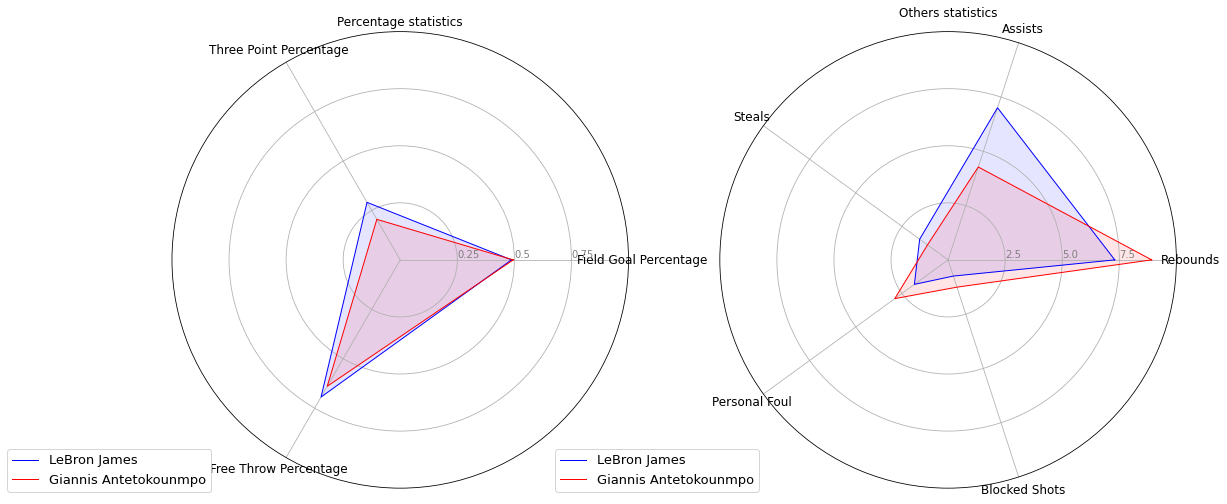

In [242]:
player_one = 'LeBron James'
player_two = 'Giannis Antetokounmpo'

stats_prct, stats_other = get_players_stats(player_one=player_one, player_two=player_two)

show_player_stats_comparison(stats_prct, stats_other)

In [246]:
def get_players_stats(player_one, player_two):
    # Remove players that didn't played at a game
    df_tmp = details[~details['MIN'].isna()]
    del df_tmp['MIN']

    # Define key statistics columns, one for percentage variable and one for other important statistics
    prct_var = ['FG_PCT', 'FG3_PCT', 'FT_PCT']
    other_var = ['REB', 'AST', 'STL', 'PF', 'BLK'] 

    # Create a specific dataset for LeBron James
    player_one_df = df_tmp[df_tmp['PLAYER_NAME'] == player_one]
    player_two_df = df_tmp[df_tmp['PLAYER_NAME'] == player_two]

    player_one_agg_prct = agg_on_columns(df=player_one_df, agg_var=prct_var, operation=['mean'])
    player_one_agg_other = agg_on_columns(df=player_one_df, agg_var=other_var, operation=['mean'])

    player_two_agg_prct = agg_on_columns(df=player_two_df, agg_var=prct_var, operation=['mean'])
    player_two_agg_other = agg_on_columns(df=player_two_df, agg_var=other_var, operation=['mean'])
    
    stats_prct = pd.concat([player_one_agg_prct, player_two_agg_prct]) 
    stats_other = pd.concat([player_one_agg_other, player_two_agg_other]) 

    stats_prct.index = [player_one, player_two]
    stats_other.index = [player_one, player_two]
    
    stats_prct = rename_df(stats_prct, col_dict=stats_cols)
    stats_other = rename_df(stats_other, col_dict=stats_cols)
    
    return stats_prct, stats_other

def show_player_stats_comparison(stats_prct, stats_other):
    fig, ax = plt.subplots(figsize=(18, 9))

    ax = plt.subplot(121, polar=True)
    ax.set_title('Percentage statistics')
    radar_plot(ax=ax, df=stats_prct, max_val=1)

    ax = plt.subplot(122, polar=True)
    ax.set_title('Others statistics')
    radar_plot(ax=ax, df=stats_other, max_val=10)

    plt.show()

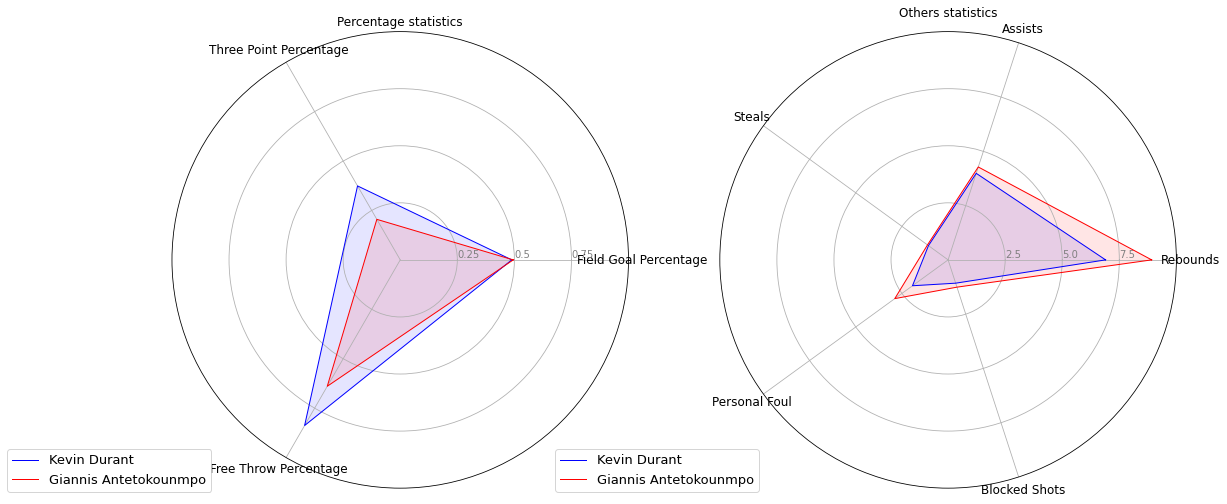

In [244]:
player_one = 'Kevin Durant'
player_two = 'Giannis Antetokounmpo'

stats_prct, stats_other = get_players_stats(player_one=player_one, player_two=player_two)

show_player_stats_comparison(stats_prct, stats_other)

Answer to Question 6:

Based on the radar plot comparisons, Kevin Durant and Giannis are definitley in the same category as LeBron, superstars. Kevin Durant leans more towards Jordan's play style with high percentage shots and more offensive ability whereas Giannis leans more towards LeBron's play style with more inside the paint shots and reb.

Nevertheless, Kevin Durant or Giannis will reign the NBA once LeBron retires and who ever can create a better legacy one LeBron leaves, will take the crown. 

Kevin Durant is similiar to Jordan and Giannis is similiar to LeBron.

# END